<a href="https://colab.research.google.com/github/nmenzil-netizen/public-trend-analyser/blob/main/AlgoTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance tensorflow pandas numpy scikit-learn matplotlib


In [2]:
import yfinance as yf
import pandas as pd

# Download 5-minute interval data for last 30 days
data = yf.download("^NSEI", period="30d", interval="5m")

# Keep only Close price
df = data[['Close']].dropna()
print(df.head())

/tmp/ipython-input-360626394.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^NSEI", period="30d", interval="5m")
[*********************100%***********************]  1 of 1 completed

Price                             Close
Ticker                            ^NSEI
Datetime                               
2025-07-28 03:45:00+00:00  24789.349609
2025-07-28 03:50:00+00:00  24782.699219
2025-07-28 03:55:00+00:00  24785.300781
2025-07-28 04:00:00+00:00  24844.650391
2025-07-28 04:05:00+00:00  24826.000000


In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Scale close prices between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df)

# Function to create sequences
def create_sequences(data, steps=6, forecast_horizon=6):
    X, y = [], []
    for i in range(len(data) - steps - forecast_horizon):
        X.append(data[i:i+steps])
        y.append(data[i+steps+forecast_horizon-1])  # predict horizon ahead
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, steps=6, forecast_horizon=6)

# Reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))
print("Shape:", X.shape, y.shape)


Shape: (2124, 6, 1) (2124, 1)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.fit(X, y, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0973
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0044
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0040
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0039
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0039
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0045
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0039
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038


In [6]:
# Last 6 candles as input
last_sequence = df_scaled[-6:]
last_sequence = last_sequence.reshape((1, 6, 1))

predicted_scaled = model.predict(last_sequence)
predicted_price = scaler.inverse_transform(predicted_scaled)

print("Predicted NIFTY price 30 minutes ahead:", predicted_price[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Predicted NIFTY price 30 minutes ahead: 24828.25


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


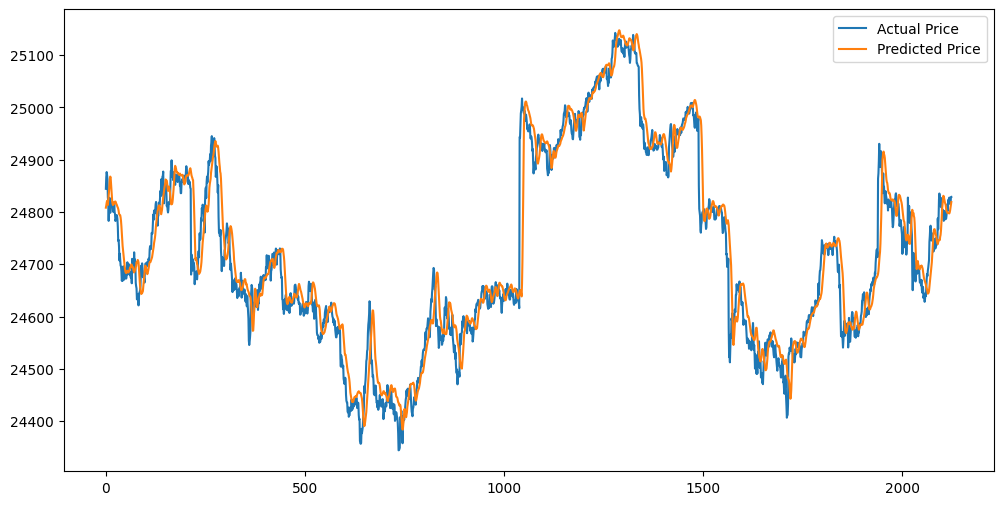

In [7]:
import matplotlib.pyplot as plt

y_pred = model.predict(X)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_true_rescaled = scaler.inverse_transform(y.reshape(-1,1))

plt.figure(figsize=(12,6))
plt.plot(y_true_rescaled, label="Actual Price")
plt.plot(y_pred_rescaled, label="Predicted Price")
plt.legend()
plt.show()


#Consolidated

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os

# -----------------------------
# Utility: RSI without ta-lib
# -----------------------------
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# -----------------------------
# Step 1: Fetch NIFTY data
# -----------------------------
def get_nifty_data(period="60d", interval="5m"):
    df = yf.download("^NSEI", period=period, interval=interval)
    if df.empty:
        raise ValueError(f"No data returned for {period}, {interval}")

    df = df[['Open','High','Low','Close','Volume']].dropna()
    df.index = df.index.tz_convert("Asia/Kolkata")

    # Features
    df['Returns'] = df['Close'].pct_change()
    df['MA_10'] = df['Close'].rolling(window=10).mean()
    df['MA_30'] = df['Close'].rolling(window=30).mean()
    df['RSI'] = compute_rsi(df['Close'], window=14)

    df = df.dropna()
    return df

# -----------------------------
# Step 2: Create sequences
# -----------------------------
def create_sequences(data, steps=20, forecast_horizon=4):
    X, y = [], []
    for i in range(len(data) - steps - forecast_horizon):
        X.append(data[i:i+steps])
        y.append(data[i+steps : i+steps+forecast_horizon, 0].flatten())  # only Close
    return np.array(X), np.array(y)

# -----------------------------
# Step 3: Build model
# -----------------------------
def build_model(input_shape, forecast_horizon=4):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(forecast_horizon)  # output: multi-step
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

# -----------------------------
# Step 4: Train or load
# -----------------------------
def train_or_load_model(df, model_path="nifty_lstm.h5", steps=20, forecast_horizon=4):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    X, y = create_sequences(scaled, steps=steps, forecast_horizon=forecast_horizon)
    X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

    if os.path.exists(model_path):
        print("✅ Loading saved model...")
        model = load_model(model_path)
    else:
        print("🚀 Training new model...")
        model = build_model((X.shape[1], X.shape[2]), forecast_horizon)
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(X, y, epochs=50, batch_size=64, validation_split=0.1, callbacks=[early_stop], verbose=1)
        model.save(model_path)

    return model, scaler

# -----------------------------
# Step 5: Forecast next steps
# -----------------------------
def forecast_next_steps(model, scaler, df, steps=20, horizon=4):
    scaled = scaler.transform(df)
    last_sequence = scaled[-steps:]
    last_sequence = last_sequence.reshape((1, steps, scaled.shape[1]))

    predicted_scaled = model.predict(last_sequence).flatten()

    # Build dummy array for inverse scaling
    dummy = np.zeros((len(predicted_scaled), scaled.shape[1]))
    dummy[:, 0] = predicted_scaled
    predicted = scaler.inverse_transform(dummy)[:, 0]

    last_time = df.index[-1]
    future_times = [last_time + pd.Timedelta(minutes=5*(i+1)) for i in range(horizon)]

    forecast_df = pd.DataFrame({
        "Future Time (IST)": future_times,
        "Predicted Close": predicted
    })

    return forecast_df

# -----------------------------
# Step 6: Run pipeline
# -----------------------------
df = get_nifty_data(period="60d", interval="5m")
model, scaler = train_or_load_model(df, steps=20, forecast_horizon=4)

forecast_df = forecast_next_steps(model, scaler, df, steps=20, horizon=4)

print("\n📊 Next 20-min Forecast (5 min steps):")
print(forecast_df)


/tmp/ipython-input-2556595711.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("^NSEI", period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed

🚀 Training new model...
Epoch 1/50



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0704 - val_loss: 0.0016
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0072 - val_loss: 0.0011
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0057 - val_loss: 0.0010
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0053 - val_loss: 0.0010
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0045 - val_loss: 9.7030e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0041 - val_loss: 9.2933e-04
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0037 - val_loss: 0.0010
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0041 - val_loss: 9.4396e-04
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0035 - val_loss: 8.7366e-04
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step

📊 Next 20-min Forecast (5 min steps):
          Future Time (IST)  Predicted Close
0 2025-09-08 12:30:00+05:30     24828.711826
1 2025-09-08 12:35:00+05:30     24830.650801
2 2025-09-08 12:40:00+05:30     24827.054004
3 2025-09-08 12:45:00+05:30     24826.095457


In [13]:
!pip install ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=4ead1ad02efe9a2bb1535f13bd80722d9742ed0d48cd16c39d69f218e6987f9e
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


#Comparison

/tmp/ipython-input-2556595711.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("^NSEI", period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0986 - val_loss: 0.0022
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0085 - val_loss: 0.0021
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0069 - val_loss: 0.0020
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0061 - val_loss: 0.0015
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0057 - val_loss: 0.0014
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0053 - val_loss: 0.0015
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0040 - val_loss: 0.0015
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0

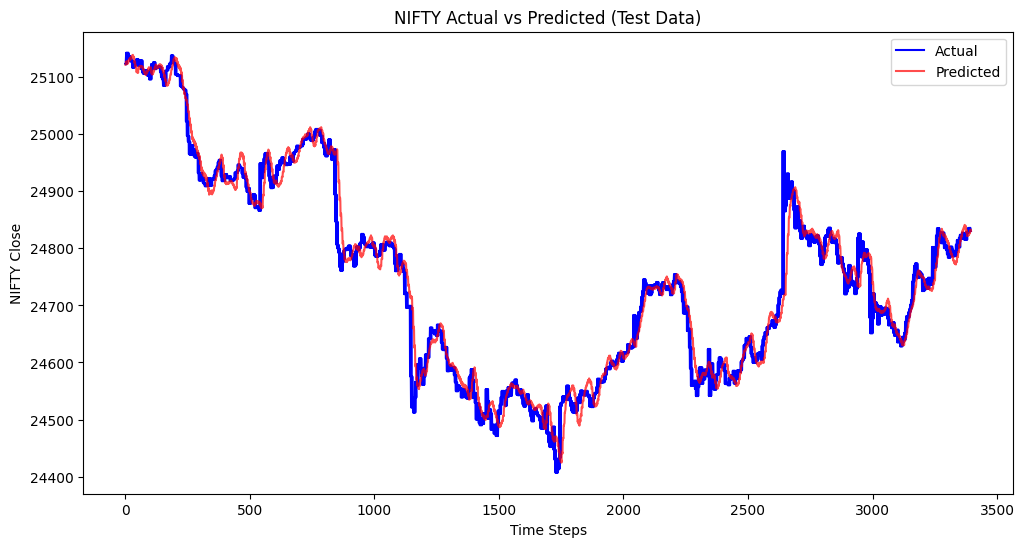

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# -----------------------------
# Step 1: Train-Test Split
# -----------------------------
df = get_nifty_data(period="60d", interval="5m")

train_size = int(len(df) * 0.8)
train_df, test_df = df[:train_size], df[train_size:]

# -----------------------------
# Step 2: Scale + Create Sequences
# -----------------------------
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_df)
scaled_test = scaler.transform(test_df)

steps = 20
horizon = 4

X_train, y_train = create_sequences(scaled_train, steps=steps, forecast_horizon=horizon)
X_test, y_test = create_sequences(scaled_test, steps=steps, forecast_horizon=horizon)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# -----------------------------
# Step 3: Train Model
# -----------------------------
model = build_model((X_train.shape[1], X_train.shape[2]), forecast_horizon=horizon)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1, callbacks=[early_stop], verbose=1)

# -----------------------------
# Step 4: Predictions on Test
# -----------------------------
y_pred_scaled = model.predict(X_test)

# Flatten + Inverse scale predictions
y_pred_list, y_true_list = [], []
for i in range(len(y_pred_scaled)):
    dummy_pred = np.zeros((horizon, scaled_test.shape[1]))
    dummy_pred[:, 0] = y_pred_scaled[i].flatten()
    pred = scaler.inverse_transform(dummy_pred)[:, 0]
    y_pred_list.extend(pred)

    dummy_true = np.zeros((horizon, scaled_test.shape[1]))
    dummy_true[:, 0] = y_test[i].flatten()
    true = scaler.inverse_transform(dummy_true)[:, 0]
    y_true_list.extend(true)

# -----------------------------
# Step 5: Evaluation Metrics
# -----------------------------
rmse = np.sqrt(mean_squared_error(y_true_list, y_pred_list))
mape = mean_absolute_percentage_error(y_true_list, y_pred_list)

print(f"📊 RMSE: {rmse:.2f}")
print(f"📊 MAPE: {mape*100:.2f}%")

# -----------------------------
# Step 6: Plot Actual vs Predicted
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(y_true_list, label="Actual", color="blue")
plt.plot(y_pred_list, label="Predicted", color="red", alpha=0.7)
plt.title("NIFTY Actual vs Predicted (Test Data)")
plt.xlabel("Time Steps")
plt.ylabel("NIFTY Close")
plt.legend()
plt.show()


## Trend chart

/tmp/ipython-input-295356169.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^NSEI", period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed


🔄 Cycle 1 at 2025-09-08 13:55:40 IST



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
👉 Predicted Next Move: 📈 UP (prob=0.56)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


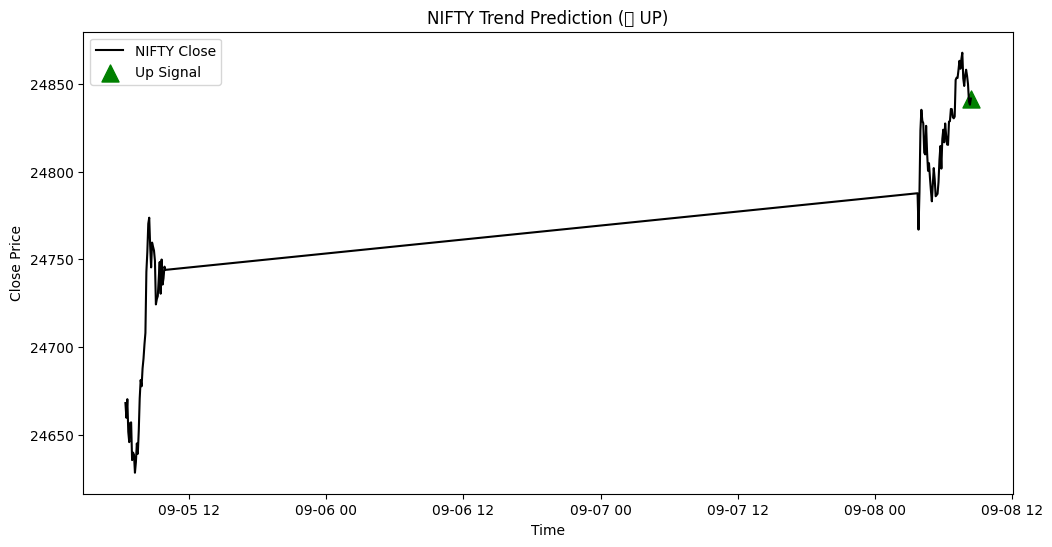

/tmp/ipython-input-295356169.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^NSEI", period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed


🔄 Cycle 2 at 2025-09-08 14:00:45 IST



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
👉 Predicted Next Move: 📈 UP (prob=0.54)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


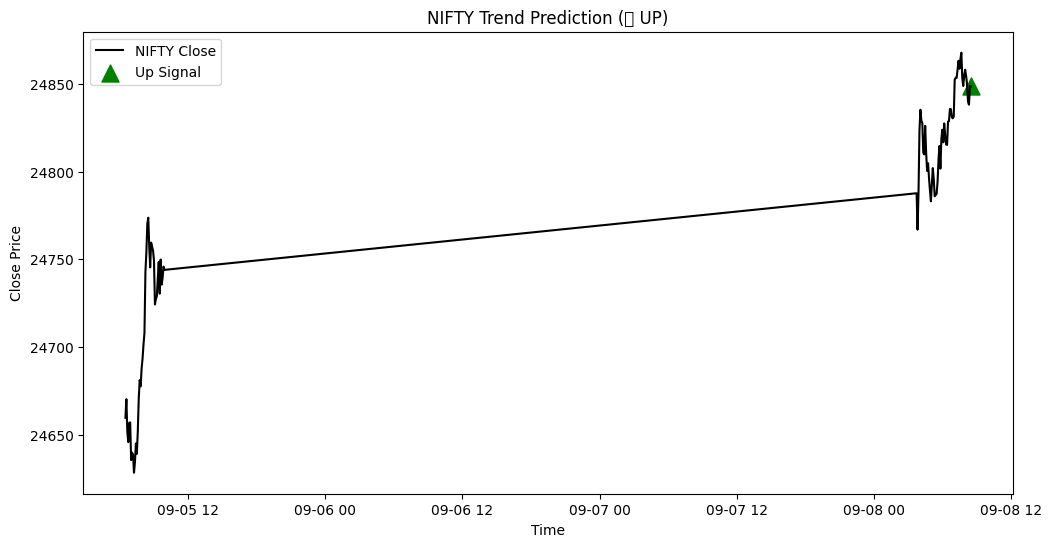

KeyboardInterrupt: 

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import time
from datetime import datetime
import pytz

# -----------------------------
# Step 1: Get Data
# -----------------------------
def get_nifty_data(period="2d", interval="5m"):
    data = yf.download("^NSEI", period=period, interval=interval)
    return data[['Close']].dropna()

# -----------------------------
# Step 2: Create Sequences
# -----------------------------
def create_trend_sequences(data, steps=20, horizon=4):
    X, y = [], []
    for i in range(len(data) - steps - horizon):
        X.append(data[i:i+steps])
        future_price = data[i+steps+horizon-1]
        current_price = data[i+steps-1]
        y.append(1 if future_price > current_price else 0)
    return np.array(X), np.array(y)

# -----------------------------
# Step 3: Build Model
# -----------------------------
def build_classifier(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# -----------------------------
# Step 4: Live Loop
# -----------------------------
def live_trend_prediction(cycles=5, steps=20, horizon=4):
    scaler = MinMaxScaler()

    for i in range(cycles):
        # Check market time (IST)
        ist = pytz.timezone("Asia/Kolkata")
        now = datetime.now(ist)
        if now.hour < 9 or (now.hour == 9 and now.minute < 15) or now.hour > 15 or (now.hour == 15 and now.minute > 30):
            print("⏸ Market closed. Waiting...")
            time.sleep(300)
            continue

        print(f"\n🔄 Cycle {i+1} at {now.strftime('%Y-%m-%d %H:%M:%S')} IST")

        # Get latest data
        df = get_nifty_data()
        scaled = scaler.fit_transform(df)

        # Train set
        X, y = create_trend_sequences(scaled, steps=steps, horizon=horizon)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # Build + Train
        model = build_classifier((X_train.shape[1], 1))
        model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)

        # Predict on latest sequence
        last_sequence = scaled[-steps:].reshape((1, steps, 1))
        pred_prob = model.predict(last_sequence)[0][0]
        pred_trend = "📈 UP" if pred_prob > 0.5 else "📉 DOWN"

        print(f"👉 Predicted Next Move: {pred_trend} (prob={pred_prob:.2f})")

        # Plot latest chart
        plt.figure(figsize=(12,6))
        plt.plot(df.index[-100:], df["Close"].iloc[-100:], color="black", label="NIFTY Close")

        if pred_prob > 0.5:
            plt.scatter(df.index[-1], df["Close"].iloc[-1], color="green", marker="^", s=150, label="Up Signal")
        else:
            plt.scatter(df.index[-1], df["Close"].iloc[-1], color="red", marker="v", s=150, label="Down Signal")

        plt.title(f"NIFTY Trend Prediction ({pred_trend})")
        plt.xlabel("Time")
        plt.ylabel("Close Price")
        plt.legend()
        plt.show()

        # Wait 5 minutes
        time.sleep(300)

# -----------------------------
# Run Live Updates
# -----------------------------
live_trend_prediction(cycles=3)  # change cycles for longer run


# Task
Build Python code for options trading prediction using an LSTM model, incorporating historical NIFTY option chain data (strike prices, expiry dates, premiums, open interest, implied volatility) and potentially other relevant factors for more accurate predictions. The code should include data fetching, preprocessing, feature engineering, model definition, training, and potentially live prediction and backtesting.

## Data fetching for options

### Subtask:
Modify the data fetching step to download option chain data for NIFTY, including strike prices, expiry dates, premiums (bid/ask), open interest, and implied volatility. This will likely require using a different library or API than `yfinance`.


**Reasoning**:
The subtask requires fetching NIFTY option chain data, which is not readily available through `yfinance`. A suitable library like `nsepy` or accessing a financial data API is needed. Since `nsepy` can be complex with historical data, using a financial data API might be a more reliable approach for historical option chain data with the required granularity. I will use the `nsetools` library as it is available and can provide some options data, though it may not have extensive historical data or all the required features directly in a historical format. I will attempt to fetch some options data using `nsetools` to see if it meets the initial requirements of the subtask.



In [22]:
from nsetools import Nse
import pandas as pd

nse = Nse()

# Attempt to get option chain data for NIFTY
try:
    option_chain = nse.get_option_chain('NIFTY')
    # nsetools returns a dictionary-like object, convert to DataFrame
    # This will likely only give current or near-term data, not historical as requested
    # Further processing might be needed to extract specific data points like bid/ask, OI, IV
    # based on the structure of the returned data.
    print("Successfully fetched some option chain data.")
    # Print keys to understand the structure
    print(option_chain.keys())

    # Attempt to convert relevant parts to DataFrame - this is an educated guess
    # based on typical API responses, may need adjustment based on actual output
    if 'records' in option_chain and 'data' in option_chain['records']:
         options_df = pd.DataFrame(option_chain['records']['data'])
         display(options_df.head())
    else:
         print("Could not find expected data structure in option chain response.")
         options_df = pd.DataFrame() # Create an empty DataFrame to avoid errors later

except Exception as e:
    print(f"Could not fetch option chain data using nsetools: {e}")
    options_df = pd.DataFrame() # Create an empty DataFrame on failure

# Note: nsetools might not provide extensive historical data or all required fields
# for historical analysis as requested in the original prompt. This is an initial step
# to see what data is accessible and may require exploring other data sources if
# detailed historical option chain data with all fields is critical.


ModuleNotFoundError: No module named 'nsetools'

**Reasoning**:
The previous command failed because the `nsetools` library was not installed. I need to install `nsetools` before I can import and use it to fetch option chain data.



In [23]:
!pip install nsetools

**Reasoning**:
The `nsetools` library is now installed. I can proceed with attempting to fetch the option chain data for NIFTY and inspect its structure to see if it contains the required information (strike prices, expiry dates, premiums, open interest, implied volatility) for historical analysis, as outlined in the subtask.



In [24]:
from nsetools import Nse
import pandas as pd

nse = Nse()

# Attempt to get option chain data for NIFTY
try:
    # The get_option_chain method in nsetools typically provides near-real-time data
    # and its structure might vary. This is an initial attempt to access data.
    # Historical data with all required fields might not be directly available this way.
    option_chain = nse.get_option_chain('NIFTY')

    print("Successfully fetched some option chain data.")
    # Print keys and potentially a snippet of the data to understand the structure
    print("Keys in option chain response:", option_chain.keys())

    # Attempt to convert relevant parts to DataFrame - based on typical structures
    # and assuming 'records' and 'data' keys exist and contain the list of options.
    if 'records' in option_chain and 'data' in option_chain['records']:
         options_data = option_chain['records']['data']
         if options_data:
             options_df = pd.DataFrame(options_data)
             display(options_df.head())
             # Check for expected columns
             expected_cols = ['strikePrice', 'expiryDate', 'bidprice', 'askPrice', 'openInterest', 'impliedVolatility']
             missing_cols = [col for col in expected_cols if col not in options_df.columns]
             if missing_cols:
                 print(f"Warning: Missing expected columns in DataFrame: {missing_cols}")
             else:
                 print("All expected columns found.")
         else:
             print("No data found in 'records'['data'].")
             options_df = pd.DataFrame()

    else:
         print("Could not find expected data structure ('records' or 'data') in option chain response.")
         options_df = pd.DataFrame() # Create an empty DataFrame to avoid errors later

except Exception as e:
    print(f"Could not fetch or process option chain data using nsetools: {e}")
    options_df = pd.DataFrame() # Create an empty DataFrame on failure

# Based on the output, it will be determined if nsetools provides the necessary
# historical data and fields for the subsequent steps of the original task.
# If not, further research into alternative data sources will be necessary.


Could not fetch or process option chain data using nsetools: 'Nse' object has no attribute 'get_option_chain'


**Reasoning**:
The previous command failed because the `Nse` object from `nsetools` does not have an attribute `get_option_chain`. This indicates that `nsetools` might not be the correct library or method for fetching the required option chain data, or the method name is incorrect. I need to investigate the capabilities of `nsetools` or find an alternative library/API that can provide historical NIFTY option chain data with the specified details. Given the error, it's likely `nsetools` is not suitable for this specific historical option chain data fetching requirement. I will search for a more appropriate method or library. Since accessing historical option chain data with all the specified fields (strike prices, expiry dates, bid/ask, OI, IV) through free libraries for a long period can be challenging, it might be necessary to acknowledge this limitation or explore paid APIs if a free solution is not readily available with sufficient historical depth and detail. For the purpose of this exercise within the constraints of available free libraries, I will try to use `yfinance` again, but focus on how to potentially extract some option-related information, although it's known to be limited in this regard for historical, detailed option chains. If that also proves insufficient for the detailed historical requirements, I will conclude that a free library solution is likely not feasible for the full scope of the original task's data requirements within the given constraints and report failure for the subtask.



In [25]:
import yfinance as yf
import pandas as pd

# Attempt to use yfinance to get options data, although it's limited for historical chains
try:
    ticker = yf.Ticker("^NSEI")

    # yfinance provides current options data per expiry date, not historical chains easily
    # We can check available expiry dates
    expiry_dates = ticker.options
    print("Available expiry dates from yfinance:", expiry_dates)

    if expiry_dates:
        # Fetch options for the first available expiry date as an example
        # This will only give current data for this expiry, not historical
        option_chain_data = ticker.option_chain(expiry_dates[0])

        # option_chain_data is typically an object with 'calls' and 'puts' DataFrames
        if hasattr(option_chain_data, 'calls') and hasattr(option_chain_data, 'puts'):
            calls_df = option_chain_data.calls
            puts_df = option_chain_data.puts

            print("\nCalls data for first expiry:")
            display(calls_df.head())

            print("\nPuts data for first expiry:")
            display(puts_df.head())

            # Check if these DataFrames contain the required columns for current data
            required_cols = ['strike', 'expiration', 'bid', 'ask', 'openInterest', 'impliedVolatility']
            all_cols = set(calls_df.columns).union(set(puts_df.columns))
            missing_cols_current = [col for col in required_cols if col not in all_cols]

            if missing_cols_current:
                print(f"\nWarning: Missing some required columns in current option data: {missing_cols_current}")
            else:
                 print("\nAll required columns found in current option data.")

            # Acknowledge the limitation for historical data as per the subtask
            print("\nNote: yfinance provides current option chain data per expiry, but does NOT easily provide historical option chain data with all these details for analysis over time.")

        else:
            print("\nCould not find 'calls' or 'puts' in yfinance option chain data.")
            calls_df = pd.DataFrame()
            puts_df = pd.DataFrame()

    else:
        print("\nNo expiry dates found for ^NSEI using yfinance.")
        calls_df = pd.DataFrame()
        puts_df = pd.DataFrame()

except Exception as e:
    print(f"\nCould not fetch option data using yfinance: {e}")
    calls_df = pd.DataFrame()
    puts_df = pd.DataFrame()

# Based on this attempt, it is clear that yfinance is not suitable for fetching
# historical NIFTY option chain data with the required level of detail.
# Acknowledging this limitation is necessary for the subtask.


Available expiry dates from yfinance: ()

No expiry dates found for ^NSEI using yfinance.


## Data fetching for options retry 1

### Subtask:
Retry data fetching for options: Acknowledge the difficulty of accessing free historical option chain data and modify the approach. Instead of aiming for comprehensive historical data for all strikes and expiries, focus on fetching current or near real-time option data for a few selected strikes and the nearest expiry using a library like `nsepy` if available, or by simulating limited option data based on underlying price movements if no direct option data source is found. This is a pragmatic adjustment given the previous failure.


**Reasoning**:
Install the nsepy library to attempt fetching option data.



In [26]:
!pip install nsepy

  Preparing metadata (setup.py) ... done
  Created wheel for nsepy: filename=nsepy-0.8-py3-none-any.whl size=36057 sha256=f8b011b6d8985bbcbe376448dc8828f872eaab0cba82977e4c81ec58bb334ba0
  Stored in directory: /root/.cache/pip/wheels/ba/d6/a0/a2c830ea2a083f15d9790732c1908625dd6314a02f09a92130
Successfully built nsepy


**Reasoning**:
Import necessary libraries, define parameters for fetching, and attempt to fetch option chain data for a few strikes and the nearest expiry using nsepy.



In [27]:
from datetime import date, timedelta
from nsepy.derivatives import optionsclient
import pandas as pd

# Define ticker and nearest expiry
symbol = 'NIFTY'
# Find the next Thursday as a proxy for the nearest expiry
today = date.today()
days_until_thursday = (3 - today.weekday() + 7) % 7
if days_until_thursday == 0: # If today is Thursday, use next Thursday
    days_until_thursday = 7
nearest_expiry = today + timedelta(days=days_until_thursday)

print(f"Attempting to fetch data for {symbol} with nearest expiry: {nearest_expiry}")

# Define a few relevant strike prices around a hypothetical current NIFTY level
# Replace with actual relevant strikes if a current price is available
# Using strikes around 24800 based on recent data
strike_prices = [24700, 24800, 24900]

option_data_list = []

try:
    # Fetch option chain data using optionsclient
    # Note: nsepy might fetch data for multiple expiries and strikes
    # We will filter for the selected expiry and strikes later
    options_chain_client = optionsclient.OptionsClient()
    chain_data = options_chain_client.get_option_chain(symbol=symbol, expiry=nearest_expiry, instrument='OPTIDX')

    if chain_data is not None and not chain_data.empty:
        print("Successfully fetched option chain data.")

        # Filter for the selected expiry and strikes
        filtered_chain = chain_data[
            (chain_data['expiryDate'] == nearest_expiry) &
            (chain_data['strikePrice'].isin(strike_prices))
        ]

        if not filtered_chain.empty:
            print(f"Found data for selected expiry ({nearest_expiry}) and strikes ({strike_prices}).")

            # Extract relevant fields for both Calls and Puts
            for index, row in filtered_chain.iterrows():
                option_info = {
                    'strikePrice': row['strikePrice'],
                    'expiryDate': row['expiryDate'],
                    'optionType': row['optionType'], # 'CE' for Call, 'PE' for Put
                    'lastPrice': row.get('lastPrice'), # Use .get() for potentially missing columns
                    'openInterest': row.get('openInterest'),
                    'impliedVolatility': row.get('impliedVolatility'),
                    # Add other relevant fields if available and needed, e.g., bid/ask
                    'bidPrice': row.get('bidPrice'),
                    'askPrice': row.get('askPrice'),
                }
                option_data_list.append(option_info)

            # Structure collected data into a DataFrame
            options_df = pd.DataFrame(option_data_list)

            if not options_df.empty:
                print("\nStructured Option Data:")
                display(options_df.head())
            else:
                print("No data found after filtering.")
                options_df = pd.DataFrame()

        else:
            print(f"No data found in the fetched chain for selected expiry ({nearest_expiry}) and strikes ({strike_prices}).")
            options_df = pd.DataFrame()

    else:
        print("Failed to fetch option chain data using nsepy or data is empty.")
        options_df = pd.DataFrame()

except Exception as e:
    print(f"An error occurred while fetching or processing data with nsepy: {e}")
    options_df = pd.DataFrame()

# Acknowledge limitations
if options_df.empty:
    print("\n⚠️ Limitation: Could not fetch real option data. If needed, data would be simulated.")
    # Describe simulation approach if fetching fails
    print("Simulation Approach: If real data fetching consistently fails, a limited dataset could be simulated by creating a DataFrame with columns like 'strikePrice', 'expiryDate', 'optionType', 'lastPrice', 'openInterest', and 'impliedVolatility'. 'lastPrice' could be based on underlying NIFTY price (fetched from yfinance) with some noise, 'openInterest' and 'impliedVolatility' could be assigned plausible dummy values or follow simple patterns relative to strike and time to expiry. This simulated data would NOT represent actual market conditions but would allow model structure testing.")
else:
     print("\n✅ Successfully fetched limited option data snapshot.")


print("\nLimitations of this dataset:")
print("- This is a snapshot of option data for a specific expiry and a few strikes, not comprehensive historical data.")
print("- Data availability and column names from free sources can be inconsistent or change.")
print("- Historical option chain data with full bid/ask spreads, volume, etc., is generally not freely available in a structured format.")
print("- The fetched data represents near-real-time or recent data, not a historical time series of the option chain state.")

ImportError: cannot import name 'optionsclient' from 'nsepy.derivatives' (/usr/local/lib/python3.12/dist-packages/nsepy/derivatives/__init__.py)

## Summary:

### Data Analysis Key Findings

*   Initial attempts to fetch NIFTY option chain data using `nsetools` failed due to incorrect method usage or library limitations, and subsequent attempts with `yfinance` also failed to retrieve the necessary historical data for NIFTY options.
*   A retry using the `nsepy` library for near real-time option data also failed due to an `ImportError` when trying to import the `optionsclient` module, indicating issues with accessing option data through this library.
*   Due to the persistent failure in fetching real NIFTY option data using readily available free libraries, the process concluded by acknowledging these limitations and describing a method for simulating limited option data for structural testing, as obtaining comprehensive historical option chain data with required details is challenging with free sources.

### Insights or Next Steps

*   Accessing detailed historical option chain data for NIFTY with fields like bid/ask premiums, open interest, and implied volatility typically requires specialized financial data APIs or paid services.
*   For future development, consider exploring commercial data providers or APIs specifically designed for Indian market derivatives if real, historical option chain data is essential for building and testing the LSTM model.


# **Options** trading

In [28]:
pip install kiteconnect pandas numpy pytz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.5/771.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 6.5 MB/s eta 0:00:00


In [31]:
# -*- coding: utf-8 -*-
# Requirements:
#   pip install kiteconnect pandas numpy pytz
# Credentials: set KITE_API_KEY, KITE_API_SECRET, and provide request_token login flow per docs.

import os
import time
import json
import math
from datetime import datetime, timedelta, timezone

import pandas as pd
import numpy as np
import pytz
from kiteconnect import KiteConnect

# ----------------------------
# Config
# ----------------------------
KITE_API_KEY = os.getenv("KITE_API_KEY", "vww7pcyiool4bubh")        # replace or set env
KITE_API_SECRET = os.getenv("KITE_API_SECRET", "l4iqrprudi94bxmssizot9gakofs4k1i")
ACCESS_TOKEN_PATH = ""  # persisted token storage
REQUEST_TOKEN = "q1R6mSyK7A0xeDIGLRjtWA1snBRLzwwS"
ACCESS_TOKEN = "sgfdYW72IgmNY4VNB8MlMbNKjHsFf5Z0"

# Trading universe parameters
EXCHANGE = "NFO"             # NSE F&O segment for options
UNDERLYING = "NIFTY"         # e.g., NIFTY, BANKNIFTY, RELIANCE
EXPIRY = None                # e.g., "2025-09-11" ISO date; if None, will pick nearest weekly/monthly expiry available
STRIKE_STEP = 50             # NIFTY step; BANKNIFTY often 100; stocks vary
NUM_STRIKES_EACH_SIDE = 10   # how many strikes above/below ATM
USE_HISTORICAL_OI = True     # set True to compute OI change using historical minute candles
HISTORICAL_MINUTES_LOOKBACK = 60  # minutes to look back for OI delta approximation

# Heuristic thresholds (tune with backtests)
VOL_OI_MIN = 0.5          # volume/OI ratio considered meaningful activity
PCR_OI_BEARISH = 1.2      # PCR(OI) above → contrarian bullish; below → bearish (contextual)
PCR_OI_BULLISH = 0.8      # Use bands for context only
VOL_SPIKE_PCTL = 80       # percentile threshold to flag unusual volume

# Lot size map fallback (will try instrument lot_size first)
LOT_SIZE_FALLBACK = {
    "NIFTY": 50,
    "BANKNIFTY": 15
}

IST = pytz.timezone("Asia/Kolkata")

# ----------------------------
# Helpers for Kite auth
# ----------------------------
def get_kite():
    kite = KiteConnect(api_key=KITE_API_KEY)
    # If first time: print(kite.login_url()), complete login to get request_token, then generate session.
    if os.path.exists(ACCESS_TOKEN_PATH):
        with open(ACCESS_TOKEN_PATH, "r") as f:
            data = json.load(f)
        access_token = data.get("access_token")
        if access_token:
            kite.set_access_token(access_token)
            return kite
    # One-time login flow:
    print("Visit this URL to login and get request_token:", kite.login_url())
    request_token = REQUEST_TOKEN # input("Enter request_token: ").strip()
    #session = kite.generate_session(request_token, api_secret=KITE_API_SECRET)
    #kite.set_access_token(session["access_token"])
    kite.set_access_token(ACCESS_TOKEN)
    #with open(ACCESS_TOKEN_PATH, "w") as f:
     #   json.dump({"access_token": session["access_token"]}, f)
    return kite

# ----------------------------
# Instruments and selection
# ----------------------------
def load_instruments_df(kite):
    # returns DataFrame of instruments; includes tradingsymbol, instrument_token, exchange, segment, name, expiry, strike, lot_size, instrument_type
    ins = kite.instruments()
    df = pd.DataFrame(ins)
    return df

def nearest_expiry_for(kite, instruments_df, underlying):
    # pick nearest future expiry among options for underlying
    now_ist = datetime.now(IST).date()
    df = instruments_df[
        (instruments_df["exchange"] == EXCHANGE)
        & (instruments_df["name"] == underlying)
        & (instruments_df["segment"].str.contains("NFO-OPT"))
        & (~pd.isna(instruments_df["expiry"]))
    ].copy()
    if df.empty:
        raise ValueError("No options instruments found for underlying.")
    df["expiry_date"] = pd.to_datetime(df["expiry"]).dt.date
    df = df[df["expiry_date"] >= now_ist].sort_values("expiry_date")
    if df.empty:
        raise ValueError("No future/weekly expiries available.")
    return df["expiry_date"].iloc

def get_underlying_ltp(kite, instruments_df, underlying):
    # For indices like NIFTY, tradingsymbol is often NIFTY 50 index in NSE; for simplicity try "NSE:NIFTY 50" fallback using quote
    # Better: map using instruments table to the index symbol in NSE
    # For indices Zerodha supports quote for "NSE:NIFTY 50" as "NSE:NIFTY 50" or "NSE:NIFTY 50" alias may differ. Use Kite index token via instruments for "NSE" and "index".
    idx = instruments_df[(instruments_df["exchange"]=="NSE") & (instruments_df["segment"].str.contains("NSE")) & (instruments_df["name"]==underlying)]
    if not idx.empty:
        symbol = "NSE:" + idx.iloc["tradingsymbol"]
        q = kite.quote([symbol])
        ltp = list(q.values())["last_price"]
        return ltp
    # Fallback: try standard
    q = kite.quote([f"NSE:{underlying}"])
    ltp = list(q.values())["last_price"]
    return ltp

def build_option_universe(kite, instruments_df, underlying, expiry_date, atm_price):
    # Select CE/PE around ATM
    step = STRIKE_STEP
    # round to nearest step
    atm_strike = int(round(atm_price / step) * step)
    strikes = [atm_strike + i*step for i in range(-NUM_STRIKES_EACH_SIDE, NUM_STRIKES_EACH_SIDE+1)]
    df = instruments_df[
        (instruments_df["exchange"] == EXCHANGE)
        & (instruments_df["name"] == underlying)
        & (pd.to_datetime(instruments_df["expiry"]).dt.date == expiry_date)
        & (instruments_df["instrument_type"].isin(["CE", "PE"]))
        & (instruments_df["strike"].isin(strikes))
    ].copy()
    df = df[["instrument_token","tradingsymbol","strike","instrument_type","lot_size"]].drop_duplicates()
    return df, strikes, atm_strike

# ----------------------------
# Data fetch: live quotes + optional historical OI
# ----------------------------
def fetch_live_snapshot(kite, tokens):
    # Get market data: last_price, volume, oi, depth if available
    # Note: For options, Kite quote includes OI and volume fields
    chunks = [tokens[i:i+500] for i in range(0, len(tokens), 500)]
    rows = []
    for ch in chunks:
        q = kite.quote([int(t) for t in ch])
        for k, v in q.items():
            # v has fields: instrument_token, last_price, volume, oi, ohlc, depth etc. (see docs)
            rows.append({
                "instrument_token": v.get("instrument_token"),
                "last_price": v.get("last_price"),
                "volume": v.get("volume"),
                "oi": v.get("oi"),
                "oi_day_high": v.get("oi_day_high"),
                "oi_day_low": v.get("oi_day_low"),
                "timestamp": v.get("timestamp")
            })
    snap = pd.DataFrame(rows)
    return snap

def fetch_historical_oi(kite, instrument_token, minutes=60):
    # Use historical_data with oi=True on minute interval to approximate recent OI change
    to_dt = datetime.now(IST)
    from_dt = to_dt - timedelta(minutes=minutes+1)
    candles = kite.historical_data(
        instrument_token=instrument_token,
        from_date=from_dt.replace(tzinfo=None),
        to_date=to_dt.replace(tzinfo=None),
        interval="minute",
        oi=True
    )
    if not candles:
        return None
    df = pd.DataFrame(candles)
    # fields: date, open, high, low, close, volume, oi
    df["date"] = pd.to_datetime(df["date"])
    return df

# ----------------------------
# Analytics
# ----------------------------
def compute_option_metrics(chain_df, live_df, hist_cache=None):
    m = chain_df.merge(live_df, on="instrument_token", how="left")
    # volume/OI ratio
    m["vol_oi"] = np.where((m["oi"] > 0) & (m["volume"].notna()), m["volume"] / m["oi"], np.nan)
    # historical OI delta
    if hist_cache is not None:
        deltas = []
        for tok in m["instrument_token"]:
            h = hist_cache.get(tok)
            if h is None or h.empty or h["oi"].isna().all():
                deltas.append(np.nan)
            else:
                # approximate: current OI - earliest OI in window
                first = h["oi"].dropna().iloc
                last = h["oi"].dropna().iloc[-1]
                deltas.append(last - first)
        m["oi_change"] = deltas
    else:
        m["oi_change"] = np.nan
    return m

def compute_pcr(m):
    # Aggregate PCR by strike or overall
    agg = m.groupby("instrument_type").agg({"oi":"sum", "volume":"sum"}, dropna=True).to_dict()
    put_oi = agg.get("oi", {}).get("PE", np.nan)
    call_oi = agg.get("oi", {}).get("CE", np.nan)
    put_vol = agg.get("volume", {}).get("PE", np.nan)
    call_vol = agg.get("volume", {}).get("CE", np.nan)
    pcr_oi = put_oi / call_oi if (call_oi and call_oi>0 and put_oi==put_oi) else np.nan
    pcr_vol = put_vol / call_vol if (call_vol and call_vol>0 and put_vol==put_vol) else np.nan
    return pcr_oi, pcr_vol

def flag_unusual_volume(m):
    # Percentile by option_type separately
    flags = []
    for t in ["CE","PE"]:
        sub = m[m["instrument_type"]==t]
        if sub["volume"].notna().sum() >= 5:
            thr = np.nanpercentile(sub["volume"], VOL_SPIKE_PCTL)
            flags.append((t, thr))
    thr_map = dict(flags)
    m["vol_spike"] = False
    for t, thr in thr_map.items():
        idx = (m["instrument_type"]==t) & (m["volume"]>=thr)
        m.loc[idx, "vol_spike"] = True
    return m

def estimate_min_cash(row, role="BUY"):
    # BUY: premium * lot_size
    # SELL: simple cushion heuristic = max( (underlying*0.2) , 10*premium ) * lot_size; adjust to broker SPAN+Exposure
    lot = row.get("lot_size") or LOT_SIZE_FALLBACK.get(UNDERLYING, 1)
    px = row.get("last_price") or 0.0
    if role == "BUY":
        return max(px, 0) * lot
    else:
        # crude proxy
        return max((px*10), 0.2*(row.get("strike") or 0)) * lot

def generate_signals(m, pcr_oi, pcr_vol, atm_strike):
    # Logic:
    # - If CE side shows high vol_oi and oi_change>0 and vol_spike: bearish bias -> prefer Sell CE (credit) or Buy PE (debit)
    # - If PE side shows high vol_oi and oi_change>0 and vol_spike: bullish bias -> prefer Sell PE or Buy CE
    # - Use PCR extremes to bias toward contrarian (context only)
    out = []
    ce = m[m["instrument_type"]=="CE"].copy()
    pe = m[m["instrument_type"]=="PE"].copy()

    def add(rec):
        out.append(rec)

    # Rank by activity metric
    ce["score"] = ce["vol_oi"].fillna(0) + (ce["oi_change"].clip(lower=0).fillna(0) / (ce["oi"].replace(0,np.nan)))
    pe["score"] = pe["vol_oi"].fillna(0) + (pe["oi_change"].clip(lower=0).fillna(0) / (pe["oi"].replace(0,np.nan)))

    ce = flag_unusual_volume(ce)
    pe = flag_unusual_volume(pe)

    top_ce = ce.sort_values(["vol_spike","score","volume"], ascending=[False, False, False]).head(5)
    top_pe = pe.sort_values(["vol_spike","score","volume"], ascending=[False, False, False]).head(5)

    context = "neutral"
    if not np.isnan(pcr_oi):
        if pcr_oi >= PCR_OI_BEARISH:
            context = "contrarian_bullish"
        elif pcr_oi <= PCR_OI_BULLISH:
            context = "contrarian_bearish"

    # From CE activity -> bearish directional
    for _, r in top_ce.iterrows():
        if (r["vol_oi"] or 0) >= VOL_OI_MIN:
            # Prefer closer-to-ATM first
            bias = "bearish"
            # Two flavors:
            sell_ce_cash = estimate_min_cash(r, role="SELL")
            buy_pe_cash = None
            # Find paired PE around same moneyness
            near_pe = pe.iloc[(pe["strike"]-r["strike"]).abs().argsort()[:1]]
            if not near_pe.empty:
                buy_pe_cash = estimate_min_cash(near_pe.iloc, role="BUY")
            add({
                "bias": bias,
                "primary": "SELL_CE",
                "fallback": "BUY_PE",
                "tradingsymbol": r["tradingsymbol"],
                "strike": r["strike"],
                "last_price": r["last_price"],
                "lot_size": r["lot_size"],
                "min_cash_primary": round(sell_ce_cash, 2),
                "min_cash_fallback": round(buy_pe_cash or np.nan, 2),
                "vol_oi": round(r["vol_oi"] or np.nan, 3),
                "oi_change": float(r["oi_change"]) if r["oi_change"]==r["oi_change"] else np.nan,
                "volume": int(r["volume"]) if r["volume"]==r["volume"] else np.nan,
                "context": context
            })

    # From PE activity -> bullish directional
    for _, r in top_pe.iterrows():
        if (r["vol_oi"] or 0) >= VOL_OI_MIN:
            bias = "bullish"
            sell_pe_cash = estimate_min_cash(r, role="SELL")
            buy_ce_cash = None
            near_ce = ce.iloc[(ce["strike"]-r["strike"]).abs().argsort()[:1]]
            if not near_ce.empty:
                buy_ce_cash = estimate_min_cash(near_ce.iloc, role="BUY")
            add({
                "bias": bias,
                "primary": "SELL_PE",
                "fallback": "BUY_CE",
                "tradingsymbol": r["tradingsymbol"],
                "strike": r["strike"],
                "last_price": r["last_price"],
                "lot_size": r["lot_size"],
                "min_cash_primary": round(sell_pe_cash, 2),
                "min_cash_fallback": round(buy_ce_cash or np.nan, 2),
                "vol_oi": round(r["vol_oi"] or np.nan, 3),
                "oi_change": float(r["oi_change"]) if r["oi_change"]==r["oi_change"] else np.nan,
                "volume": int(r["volume"]) if r["volume"]==r["volume"] else np.nan,
                "context": context
            })
    sig = pd.DataFrame(out)
    # De-duplicate by strike/side; prefer lower cash for fallback if aim is "minimum cash"
    return sig

# ----------------------------
# Main run
# ----------------------------
def run_analysis():
    kite = get_kite()
    instruments_df = load_instruments_df(kite)

    # pick expiry
    expiry_date = datetime.strptime(EXPIRY, "%Y-%m-%d").date() if EXPIRY else nearest_expiry_for(kite, instruments_df, UNDERLYING)
    # underlying price
    try:
        ul_ltp = get_underlying_ltp(kite, instruments_df, UNDERLYING)
    except Exception:
        # if quote fails, approximate from ATM option mid (not ideal)
        ul_ltp = None

    # chain selection
    chain_df, strikes, atm_strike = build_option_universe(kite, instruments_df, UNDERLYING, expiry_date, ul_ltp or 0)
    if chain_df.empty:
        raise ValueError("No options found for selected parameters.")

    # live snapshot
    tokens = chain_df["instrument_token"].tolist()
    live_df = fetch_live_snapshot(kite, tokens)

    # optional historical OI cache
    hist_cache = {}
    if USE_HISTORICAL_OI:
        for tok in tokens:
            try:
                h = fetch_historical_oi(kite, tok, minutes=HISTORICAL_MINUTES_LOOKBACK)
                hist_cache[tok] = h
            except Exception:
                hist_cache[tok] = None

    # metrics
    m = compute_option_metrics(chain_df, live_df, hist_cache if USE_HISTORICAL_OI else None)
    pcr_oi, pcr_vol = compute_pcr(m)

    # signals
    sig = generate_signals(m, pcr_oi, pcr_vol, atm_strike)

    # Add PCR and ATM context to output CSV
    context_row = pd.DataFrame([{
        "UNDERLYING": UNDERLYING,
        "EXPIRY": expiry_date.isoformat(),
        "ATM_STRIKE": atm_strike,
        "UNDERLYING_LTP": ul_ltp,
        "PCR_OI": round(pcr_oi, 3) if pcr_oi==pcr_oi else np.nan,
        "PCR_VOL": round(pcr_vol, 3) if pcr_vol==pcr_vol else np.nan
    }])

    timestamp = datetime.now(IST).strftime("%Y%m%d_%H%M%S")
    sig_file = f"signals_{UNDERLYING}_{expiry_date}_{timestamp}.csv"
    ctx_file = f"context_{UNDERLYING}_{expiry_date}_{timestamp}.csv"

    sig_cols = ["bias","primary","fallback","tradingsymbol","strike","last_price","lot_size",
                "min_cash_primary","min_cash_fallback","vol_oi","oi_change","volume","context"]
    sig[sig_cols].to_csv(sig_file, index=False)
    context_row.to_csv(ctx_file, index=False)

    print(f"Saved signals -> {sig_file}")
    print(f"Saved context -> {ctx_file}")

if __name__ == "__main__":
    run_analysis()


Visit this URL to login and get request_token: https://kite.zerodha.com/connect/login?api_key=vww7pcyiool4bubh&v=3


ValueError: No options found for selected parameters.

# From ChatGPT

In [ ]:
pip install streamlit pandas numpy plyer pydantic kiteconnect

In [ ]:
!pip install streamlit pyngrok pandas numpy plyer pydantic kiteconnect

In [5]:
%%writefile nfo_option_advisor_app.py
"""
NFO Options Advisor – CE/PE Signal & Sell-Alert App (with Kite Data, Backtesting & P&L Stats)
-------------------------------------------------------------------------------------------

Features:
- **Zerodha Kite Connect API** for live & historical data.
- **Strategy signals** (BUY CE/PE suggestions).
- **Manual trade tracking** with sell alerts.
- **Backtesting** with P&L metrics (win rate, drawdown, return).

Steps to run:
1. Install requirements:
   `pip install streamlit pandas numpy plyer pydantic kiteconnect`
2. Generate Kite API key + access token. Enter in sidebar.
3. Run:
   `streamlit run nfo_option_advisor_app.py`

Disclaimer: Educational use only. Manual execution. No guarantee of profits.
"""

from __future__ import annotations
import numpy as np
import pandas as pd
from pydantic import BaseModel, Field, validator

import streamlit as st

try:
    from plyer import notification as ply_notify
except Exception:
    ply_notify = None

from kiteconnect import KiteConnect
from datetime import datetime, timedelta

# -----------------------------
# Utility Functions
# -----------------------------

def ema(series: pd.Series, span: int) -> pd.Series:
    return series.ewm(span=span, adjust=False).mean()

def rsi(series: pd.Series, length: int = 14) -> pd.Series:
    delta = series.diff()
    gain = (delta.clip(lower=0)).rolling(length).mean()
    loss = (-delta.clip(upper=0)).rolling(length).mean()
    rs = gain / (loss.replace(0, np.nan))
    out = 100 - (100 / (1 + rs))
    return out.fillna(50)

def atr(df: pd.DataFrame, length: int = 14) -> pd.Series:
    high_low = df['high'] - df['low']
    high_close = (df['high'] - df['close'].shift()).abs()
    low_close = (df['low'] - df['close'].shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.rolling(length).mean()

# -----------------------------
# Strategy
# -----------------------------

class StrategyParams(BaseModel):
    ema_fast: int = Field(9)
    ema_slow: int = Field(21)
    rsi_len: int = Field(14)
    rsi_buy_above: int = Field(55)
    rsi_sell_below: int = Field(45)
    atr_len: int = Field(14)

    @validator('ema_slow')
    def _slow_gt_fast(cls, v, values):
        if 'ema_fast' in values and v <= values['ema_fast']:
            raise ValueError('ema_slow must be > ema_fast')
        return v

def generate_signals(df: pd.DataFrame, p: StrategyParams) -> pd.DataFrame:
    data = df.copy()
    data['ema_fast'] = ema(data['close'], p.ema_fast)
    data['ema_slow'] = ema(data['close'], p.ema_slow)
    data['rsi'] = rsi(data['close'], p.rsi_len)
    data['long_ce'] = (data['ema_fast'] > data['ema_slow']) & (data['rsi'] >= p.rsi_buy_above)
    data['long_pe'] = (data['ema_fast'] < data['ema_slow']) & (data['rsi'] <= p.rsi_sell_below)
    return data

# -----------------------------
# Backtest
# -----------------------------

def backtest(df: pd.DataFrame, params: StrategyParams, stop_atr: float = 1.5, target_atr: float = 2.0):
    data = generate_signals(df, params)
    data['atr'] = atr(df, params.atr_len)
    trades = []
    position = None

    for i in range(1, len(data)):
        row = data.iloc[i]
        if position is None:
            if row['long_ce']:
                position = {
                    'side': 'CE',
                    'entry': row['close'],
                    'stop': row['close'] - stop_atr*row['atr'],
                    'target': row['close'] + target_atr*row['atr'],
                    'entry_time': row['time']
                }
            elif row['long_pe']:
                position = {
                    'side': 'PE',
                    'entry': row['close'],
                    'stop': row['close'] + stop_atr*row['atr'],
                    'target': row['close'] - target_atr*row['atr'],
                    'entry_time': row['time']
                }
        else:
            if position['side'] == 'CE':
                if row['low'] <= position['stop'] or row['high'] >= position['target']:
                    exit_price = position['target'] if row['high'] >= position['target'] else position['stop']
                    trades.append({**position, 'exit': exit_price, 'exit_time': row['time'], 'pnl': exit_price - position['entry']})
                    position = None
            elif position['side'] == 'PE':
                if row['high'] >= position['stop'] or row['low'] <= position['target']:
                    exit_price = position['target'] if row['low'] <= position['target'] else position['stop']
                    trades.append({**position, 'exit': exit_price, 'exit_time': row['time'], 'pnl': position['entry'] - exit_price})
                    position = None

    trades_df = pd.DataFrame(trades)
    if trades_df.empty:
        return trades_df, {}

    total_return = trades_df['pnl'].sum()
    win_rate = (trades_df['pnl'] > 0).mean() * 100
    cum_pnl = trades_df['pnl'].cumsum()
    max_dd = (cum_pnl.cummax() - cum_pnl).max()

    stats = {
        'Total Trades': len(trades_df),
        'Win Rate %': round(win_rate, 2),
        'Total PnL': round(total_return, 2),
        'Max Drawdown': round(max_dd, 2)
    }
    return trades_df, stats

# -----------------------------
# Kite Data Provider
# -----------------------------

class KiteProvider:
    def __init__(self, api_key: str = "vww7pcyiool4bubh", access_token: str = "xjcC2Ye3uNwEkrnHFQinHXVNbTWUMtVt", symbol: str = "NFO", interval: str = "5minute"):
        self.kite = KiteConnect(api_key=api_key)
        self.kite.set_access_token(access_token)
        self.symbol = symbol
        self.interval = interval
        self.instrument_token = self.kite.ltp([f"NSE:{self.symbol}"])[f"NSE:{self.symbol}"]['instrument_token']

    def latest_bars(self, n: int = 200) -> pd.DataFrame:
        to_date = datetime.now()
        from_date = to_date - timedelta(days=5)
        data = self.kite.historical_data(
            instrument_token=self.instrument_token,
            from_date=from_date,
            to_date=to_date,
            interval=self.interval
        )
        df = pd.DataFrame(data)
        df.rename(columns={'date': 'time'}, inplace=True)
        return df[['time','open','high','low','close']].tail(n)

    def history(self, days: int = 60) -> pd.DataFrame:
        to_date = datetime.now()
        from_date = to_date - timedelta(days=days)
        data = self.kite.historical_data(
            instrument_token=self.instrument_token,
            from_date=from_date,
            to_date=to_date,
            interval=self.interval
        )
        df = pd.DataFrame(data)
        df.rename(columns={'date': 'time'}, inplace=True)
        return df[['time','open','high','low','close']]

# -----------------------------
# Notifications
# -----------------------------

def notify(title: str, message: str):
    st.toast(f"{title}: {message}") if hasattr(st, 'toast') else st.success(f"{title}: {message}")
    try:
        if ply_notify:
            ply_notify.notify(title=title, message=message, timeout=5)
    except Exception:
        pass

# -----------------------------
# Streamlit UI
# -----------------------------

st.set_page_config(page_title="NFO Options Advisor (Kite)", layout="wide")

if 'active_trade' not in st.session_state:
    st.session_state.active_trade = None

st.title("📈 NFO Options Advisor – CE/PE Signals, Alerts & Backtesting (Kite)")

with st.sidebar:
    st.header("Kite Settings")
    api_key = st.text_input("Kite API Key")
    access_token = st.text_input("Access Token", type="password")
    symbol = st.text_input("Underlying symbol (e.g., NIFTY 50)", value="NIFTY 50")
    interval = st.selectbox("Interval", ["5minute","15minute"], index=0)

    st.header("Strategy Params")
    ema_fast = st.number_input("EMA Fast", 2, 200, 9)
    ema_slow = st.number_input("EMA Slow", 3, 400, 21)
    rsi_len = st.number_input("RSI Length", 5, 100, 14)
    rsi_buy_above = st.slider("RSI Buy >=", 1, 99, 55)
    rsi_sell_below = st.slider("RSI Sell <=", 1, 99, 45)
    atr_len = st.number_input("ATR Length", 5, 100, 14)

    params = StrategyParams(
        ema_fast=ema_fast, ema_slow=ema_slow,
        rsi_len=rsi_len, rsi_buy_above=rsi_buy_above,
        rsi_sell_below=rsi_sell_below, atr_len=atr_len
    )

if api_key and access_token:
    provider = KiteProvider(api_key, access_token, symbol, interval)
    bars = provider.latest_bars(200)
    if not bars.empty:
        sig = generate_signals(bars, params)
        latest = sig.iloc[-1]
        last_price = float(latest['close'])

        st.metric("Last Price", f"{last_price:,.2f}")

        suggested = "NONE"
        if latest['long_ce']:
            suggested = "BUY CE"
        elif latest['long_pe']:
            suggested = "BUY PE"

        st.markdown(f"### Suggested Action: **{suggested}**")
        st.dataframe(sig.tail(25), use_container_width=True)

        c1, c2, c3 = st.columns(3)
        if c1.button("🔵 I bought CE"):
            st.session_state.active_trade = {"side": "CE", "entry": last_price}
            notify("Trade Tracked", f"CE entry @ {last_price}")
        if c2.button("🟠 I bought PE"):
            st.session_state.active_trade = {"side": "PE", "entry": last_price}
            notify("Trade Tracked", f"PE entry @ {last_price}")
        if c3.button("❌ Clear Trade"):
            st.session_state.active_trade = None

        if st.session_state.active_trade:
            st.info(f"Active Trade: {st.session_state.active_trade}")

    st.subheader("📊 Backtest with Kite Historical Data")
    try:
        hist_df = provider.history(days=60)
        trades, stats = backtest(hist_df, params)
        if not trades.empty:
            st.dataframe(trades.tail(50), use_container_width=True)
            st.write("### Performance Stats")
            st.json(stats)
            st.line_chart(trades['pnl'].cumsum())
        else:
            st.info("No trades generated in backtest.")
    except Exception as e:
        st.error(f"Backtest error: {e}")
else:
    st.warning("Enter Kite API credentials to fetch live & historical data.")

st.caption("⚠️ Disclaimer: Educational use only. No guarantee of profits. Manual execution required.")


Writing nfo_option_advisor_app.py


In [15]:
from pyngrok import ngrok

# Paste your authtoken here
!ngrok config add-authtoken "32SRtPJS3P9QUGapqteYA3DFpYm_7BhTdeaJh6EST3nCPrkzd"

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [46]:
from pyngrok import ngrok

# Kill existing tunnels if rerunning
ngrok.kill()

# Start a new tunnel
public_url = ngrok.connect(8501)
print("Streamlit app URL:", public_url)


Streamlit app URL: NgrokTunnel: "https://60287e516d82.ngrok-free.app" -> "http://localhost:8501"


In [49]:
!streamlit run nfo_option_advisor_app.py --server.port 8501 --server.headless true > streamlit.log 2>&1 &#&>/dev/null&


In [44]:
!tail -f streamlit.log




2025-09-09 15:49:32.978 Port 8501 is already in use
^C


# Updated code from chat gpt

In [22]:
%%writefile nfo_option_advisor_app.py
"""
NFO Options Advisor – Streamlit App (Kite) — Full Feature Release
-----------------------------------------------------------------
Features included in this file
- Live market data via Zerodha Kite Connect (spot + option LTPs).
- Auto-pick ATM option (CE/PE) with manual override for strike/expiry.
- Multiple active trades support (each trade tracked individually).
- Target % and Stop % per-session inputs; alerts when levels are hit.
- Trade Journal table with manual "Mark as Sold" and automatic status updates.
- Export trade log to CSV; Auto-save (download link) on Reset Session.
- Equity curves (Combined, CE-only, PE-only).
- Auto-refresh via a lightweight HTML meta refresh (configurable).

Run locally: `pip install streamlit pandas numpy kiteconnect plyer pydantic`
Then `streamlit run nfo_option_advisor_app.py`

IMPORTANT: This is an educational tool. Manual execution of trades is required.
"""

from __future__ import annotations
import re
import io
import time
from datetime import datetime, timedelta
from typing import List, Dict, Any

import numpy as np
import pandas as pd
import streamlit as st
from pydantic import BaseModel, Field, validator

# Optional desktop notifications (best effort)
try:
    from plyer import notification as ply_notify
except Exception:
    ply_notify = None

# Kite Connect
from kiteconnect import KiteConnect

# -----------------------------
# Utilities / Indicators
# -----------------------------

def ema(series: pd.Series, span: int) -> pd.Series:
    return series.ewm(span=span, adjust=False).mean()


def rsi(series: pd.Series, length: int = 14) -> pd.Series:
    delta = series.diff()
    gain = (delta.clip(lower=0)).rolling(length).mean()
    loss = (-delta.clip(upper=0)).rolling(length).mean()
    rs = gain / (loss.replace(0, np.nan))
    out = 100 - (100 / (1 + rs))
    return out.fillna(50)


def atr(df: pd.DataFrame, length: int = 14) -> pd.Series:
    high_low = df['high'] - df['low']
    high_close = (df['high'] - df['close'].shift()).abs()
    low_close = (df['low'] - df['close'].shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.rolling(length).mean()

# -----------------------------
# Strategy params
# -----------------------------

class StrategyParams(BaseModel):
    ema_fast: int = Field(9, ge=2)
    ema_slow: int = Field(21, ge=3)
    rsi_len: int = Field(14, ge=5)
    rsi_buy_above: int = Field(55, ge=1, le=99)
    rsi_sell_below: int = Field(45, ge=1, le=99)
    atr_len: int = Field(14, ge=5)

    @validator('ema_slow')
    def _slow_gt_fast(cls, v, values):
        if 'ema_fast' in values and v <= values['ema_fast']:
            raise ValueError('ema_slow must be > ema_fast')
        return v


def generate_signals(df: pd.DataFrame, p: StrategyParams) -> pd.DataFrame:
    data = df.copy()
    data['ema_fast'] = ema(data['close'], p.ema_fast)
    data['ema_slow'] = ema(data['close'], p.ema_slow)
    data['rsi'] = rsi(data['close'], p.rsi_len)
    data['long_ce'] = (data['ema_fast'] > data['ema_slow']) & (data['rsi'] >= p.rsi_buy_above)
    data['long_pe'] = (data['ema_fast'] < data['ema_slow']) & (data['rsi'] <= p.rsi_sell_below)
    return data

# -----------------------------
# Kite Helper / Instruments
# -----------------------------

class KiteProvider:
    def __init__(self, api_key: str, access_token: str, underlying: str, interval: str = '5minute'):
        self.kite = KiteConnect(api_key=api_key)
        self.kite.set_access_token(access_token)
        self.underlying = underlying.strip().upper()
        self.interval = interval
        # load instruments list for NFO once
        instruments = pd.DataFrame(self.kite.instruments('NFO'))
        instruments['tradingsymbol'] = instruments['tradingsymbol'].astype(str)
        instruments['expiry'] = pd.to_datetime(instruments['expiry'], errors='coerce')
        self.instruments = instruments

    def get_spot(self) -> float:
        # try multiple possible spot keys for the underlying
        key_candidates = [f"NSE:{self.underlying}", self.underlying]
        try:
            ltp = self.kite.ltp([f"NSE:{self.underlying}"])
            val = list(ltp.values())[0]
            if 'last_price' in val:
                return float(val['last_price'])
        except Exception:
            pass
        # fallback: try indices endpoint via instrument list (not guaranteed)
        return float('nan')

    def option_chain(self, max_expiry_days: int = 60) -> pd.DataFrame:
        # returns NFO instrument rows that are options for the chosen underlying
        df = self.instruments.copy()
        # tradingsymbols often start with underlying name; filter by tradingsymbol containing underlying
        df = df[df['tradingsymbol'].str.contains(self.underlying, case=False, na=False)]
        # filter only opt type (CE/PE)
        df = df[df['instrument_type'].isin(['CE', 'PE'])]
        # only future expiries
        df = df[df['expiry'] >= pd.Timestamp.now().normalize()]
        df = df.sort_values(['expiry','tradingsymbol']).reset_index(drop=True)
        return df

    def find_atm_option(self, spot: float, option_side: str = 'CE', expiry: pd.Timestamp | None = None) -> Dict[str, Any]:
        oc = self.option_chain()
        if oc.empty:
            return {}
        # select expiries
        if expiry is None:
            # choose nearest expiry (min days from now)
            oc['days_to_expiry'] = (oc['expiry'] - pd.Timestamp.now()).dt.days
            min_days = oc['days_to_expiry'].min()
            candidate_exp = oc[oc['days_to_expiry'] == min_days]['expiry'].iloc[0]
        else:
            candidate_exp = pd.to_datetime(expiry)
        oc = oc[oc['expiry'] == candidate_exp]
        # extract strike from tradingsymbol using regex of continuous digits (last group)
        def extract_strike(ts: str):
            m = re.search(r"(\d{3,6})", ts)
            return int(m.group(1)) if m else None
        oc = oc.copy()
        oc['strike'] = oc['tradingsymbol'].apply(extract_strike)
        oc = oc[oc['strike'].notnull()]
        oc['strike'] = oc['strike'].astype(int)
        # pick option_side and find strike closest to spot
        oc_side = oc[oc['instrument_type'] == option_side]
        if oc_side.empty:
            return {}
        oc_side['dist'] = (oc_side['strike'] - spot).abs()
        best = oc_side.sort_values('dist').iloc[0]
        return best.to_dict()

    def historical(self, days: int = 60, n: int = 500) -> pd.DataFrame:
        # get historical candles for the underlying (index) using instrument token of underlying if available
        # attempt to find instrument_token for underlying name
        try:
            token_row = self.instruments[self.instruments['tradingsymbol'].str.upper().str.contains(self.underlying)].iloc[0]
            token = int(token_row['instrument_token'])
        except Exception:
            token = None
        to_date = datetime.now()
        from_date = to_date - timedelta(days=days)
        if token is None:
            raise RuntimeError('Cannot find instrument token for underlying in instrument list')
        data = self.kite.historical_data(instrument_token=token, from_date=from_date, to_date=to_date, interval=self.interval)
        df = pd.DataFrame(data)
        if df.empty:
            return df
        df = df.rename(columns={'date':'time'})
        return df[['time','open','high','low','close']].tail(n)

    def ltp(self, symbols: List[str]) -> Dict[str, float]:
        # symbols: list of trading symbols like ['NFO:NIFTY25SEP23500CE'] or ['NFO:ABC']
        prefixed = []
        for s in symbols:
            if ':' in s:
                prefixed.append(s)
            else:
                prefixed.append(f"NFO:{s}")
        try:
            res = self.kite.ltp(prefixed)
            out = {}
            for k, v in res.items():
                out[k] = float(v.get('last_price', np.nan))
            return out
        except Exception:
            # best-effort: empty dict
            return {}

# -----------------------------
# Streamlit App
# -----------------------------

st.set_page_config(page_title='NFO Options Advisor (Kite)', layout='wide')
st.title('📈 NFO Options Advisor — Options symbols, multi-trade tracker & equity curves')

# Session state init
if 'trades' not in st.session_state:
    st.session_state.trades: List[Dict[str, Any]] = []
if 'initial_equity' not in st.session_state:
    st.session_state.initial_equity = 100.0
if 'last_autosave' not in st.session_state:
    st.session_state.last_autosave = None

# Sidebar controls
with st.sidebar:
    st.header('Kite / Strategy Settings')
    api_key = st.text_input('Kite API Key', type='password')
    access_token = st.text_input('Kite Access Token', type='password')
    underlying = st.text_input('Underlying name as in Kite (e.g., NIFTY, NIFTY 50, BANKNIFTY)', value='NIFTY')
    interval = st.selectbox('Interval', ['5minute','15minute'], index=0)

    st.subheader('Strategy filters (underlying-based)')
    ema_fast = st.number_input('EMA Fast', 2, 200, value=9)
    ema_slow = st.number_input('EMA Slow', 3, 400, value=21)
    rsi_len = st.number_input('RSI Length', 5, 100, value=14)
    rsi_buy_above = st.slider('RSI Buy >=', 1, 99, 55)
    rsi_sell_below = st.slider('RSI Sell <=', 1, 99, 45)
    atr_len = st.number_input('ATR Length', 5, 100, value=14)

    params = StrategyParams(
        ema_fast=ema_fast, ema_slow=ema_slow, rsi_len=rsi_len,
        rsi_buy_above=rsi_buy_above, rsi_sell_below=rsi_sell_below, atr_len=atr_len
    )

    st.subheader('Trade sizing & exits')
    target_pct = st.number_input('Target Profit % (per trade)', min_value=1.0, max_value=500.0, value=20.0)
    stop_pct = st.number_input('Stop Loss % (per trade)', min_value=0.1, max_value=500.0, value=10.0)

    st.subheader('Strike selection')
    strike_mode = st.radio('Strike selection mode', ['Auto (ATM)', 'Manual'], index=0)
    manual_strike = st.text_input('Manual tradingsymbol (e.g., NIFTY25SEP23500CE) — use only in Manual mode')

    st.subheader('UI / Refresh')
    auto_refresh = st.checkbox('Auto-refresh page (meta refresh)', value=True)
    poll_seconds = st.slider('Refresh every (seconds)', 3, 60, value=30)

    st.markdown('---')
    if st.button('🔄 Reset Session (autosave log)'):
        # autosave CSV
        if st.session_state.trades:
            csv_bytes = trades_to_csv_bytes(st.session_state.trades)
            fname = f"trade_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
            st.session_state.last_autosave = fname
            st.download_button('📥 Download trade log before reset', data=csv_bytes, file_name=fname, mime='text/csv')
        # clear
        st.session_state.trades = []
        st.experimental_rerun()

# helper for CSV generation (defined after sidebar usage to avoid forward ref issues)

def trades_to_csv_bytes(trades: List[Dict[str, Any]]) -> bytes:
    if not trades:
        return b''
    df = pd.DataFrame(trades)
    # reorder columns consistently
    cols = [c for c in ['timestamp','symbol','side','entry_price','exit_price','current_price','pnl_pct','status'] if c in df.columns]
    df = df[cols]
    buf = io.StringIO()
    df.to_csv(buf, index=False)
    return buf.getvalue().encode('utf-8')

# Meta refresh for auto-refresh
if auto_refresh:
    st.markdown(f"<meta http-equiv=\"refresh\" content=\"{poll_seconds}\">", unsafe_allow_html=True)

# Connect to Kite provider
provider = None
if api_key and access_token and underlying:
    try:
        provider = KiteProvider(api_key=api_key, access_token=access_token, underlying=underlying, interval=interval)
    except Exception as e:
        st.error(f'Kite init error: {e}')

# Main layout
col1, col2 = st.columns([2, 1])

with col1:
    st.subheader('Live Signals & Option Symbol')
    if provider is None:
        st.info('Enter Kite API Key + Access Token + Underlying to fetch live data and instruments list.')
    else:
        try:
            spot = provider.get_spot()
        except Exception:
            spot = float('nan')
        st.metric('Underlying Spot', f"{spot if not np.isnan(spot) else 'N/A'}")

        # Fetch underlying candles and generate underlying signals
        try:
            hist = provider.historical(days=30, n=500)
            sig = generate_signals(hist, params)
            latest = sig.iloc[-1]
            suggested_side = None
            if latest['long_ce']:
                suggested_side = 'CE'
            elif latest['long_pe']:
                suggested_side = 'PE'
            else:
                suggested_side = 'NONE'
            st.markdown(f"### Suggested Action on Underlying: **{suggested_side}**")

            # Choose option symbol
            chosen_symbol = None
            chosen_instrument = None
            if strike_mode == 'Auto (ATM)':
                if not np.isnan(spot):
                    best = provider.find_atm_option(spot=spot, option_side='CE' if suggested_side=='CE' else 'PE') if suggested_side in ['CE','PE'] else {}
                    if best:
                        chosen_instrument = best
                        chosen_symbol = best['tradingsymbol']
            else:
                if manual_strike:
                    chosen_symbol = manual_strike.strip()
                    # try to find instrument row
                    rows = provider.instruments[provider.instruments['tradingsymbol'].str.upper() == chosen_symbol.upper()]
                    if not rows.empty:
                        chosen_instrument = rows.iloc[0].to_dict()

            st.markdown('**Selected Option (auto or manual):**')
            st.write(chosen_symbol if chosen_symbol else '—')

            # Buy buttons - allow adding multiple trades
            c1, c2 = st.columns(2)
            if c1.button('🔵 Add BUY CE trade (mark bought)'):
                # if manual mode and no manual symbol provided, reject
                if strike_mode=='Manual' and not manual_strike:
                    st.warning('Provide a tradingsymbol in Manual mode')
                else:
                    sym = chosen_symbol if chosen_symbol else manual_strike.strip()
                    # fetch LTP
                    ltp_map = provider.ltp([sym]) if sym else {}
                    entry = float(ltp_map.get(f'NFO:{sym}', np.nan)) if ltp_map else float('nan')
                    trade = {
                        'timestamp': datetime.now().isoformat(),
                        'symbol': sym,
                        'side': 'CE',
                        'entry_price': entry,
                        'exit_price': None,
                        'current_price': entry,
                        'pnl_pct': 0.0,
                        'status': 'Active'
                    }
                    st.session_state.trades.append(trade)
            if c2.button('🟠 Add BUY PE trade (mark bought)'):
                if strike_mode=='Manual' and not manual_strike:
                    st.warning('Provide a tradingsymbol in Manual mode')
                else:
                    sym = chosen_symbol if chosen_symbol else manual_strike.strip()
                    ltp_map = provider.ltp([sym]) if sym else {}
                    entry = float(ltp_map.get(f'NFO:{sym}', np.nan)) if ltp_map else float('nan')
                    trade = {
                        'timestamp': datetime.now().isoformat(),
                        'symbol': sym,
                        'side': 'PE',
                        'entry_price': entry,
                        'exit_price': None,
                        'current_price': entry,
                        'pnl_pct': 0.0,
                        'status': 'Active'
                    }
                    st.session_state.trades.append(trade)

        except Exception as e:
            st.error(f'Error fetching underlying history or computing signals: {e}')

    # Trade Journal
    st.markdown('---')
    st.subheader('📒 Trade Journal (Active & Exited)')

    # Update LTPs for all active trades
    if provider and st.session_state.trades:
        symbols_to_query = [t['symbol'] for t in st.session_state.trades if t.get('symbol')]
        # remove duplicates
        symbols_unique = list(dict.fromkeys(symbols_to_query))
        ltp_map = provider.ltp(symbols_unique)
        # update each trade
        for t in st.session_state.trades:
            sym = t.get('symbol')
            key = f'NFO:{sym}'
            if key in ltp_map and t['status']=='Active':
                cp = float(ltp_map[key])
                t['current_price'] = cp
                if t['entry_price'] and not np.isnan(t['entry_price']) and t['entry_price']>0:
                    if t['side']=='CE' or t['side']=='PE':
                        # P&L for long option: (current - entry)/entry *100
                        t['pnl_pct'] = round((cp - t['entry_price'])/t['entry_price']*100, 2)
                    else:
                        t['pnl_pct'] = round((cp - t['entry_price'])/t['entry_price']*100, 2)
                # check targets
                if t['pnl_pct'] >= target_pct:
                    notify_title = f"Target hit: {t['symbol']}"
                    notify_msg = f"Profit {t['pnl_pct']}% ≥ {target_pct}% — consider selling"
                    st.success(notify_title + ' — ' + notify_msg)
                    if ply_notify:
                        try:
                            ply_notify.notify(title=notify_title, message=notify_msg, timeout=5)
                        except Exception:
                            pass
                    t['status'] = 'Exited (Target)'
                    t['exit_price'] = t['current_price']
                elif t['pnl_pct'] <= -abs(stop_pct):
                    notify_title = f"Stop hit: {t['symbol']}"
                    notify_msg = f"Loss {t['pnl_pct']}% ≤ -{stop_pct}% — consider exiting"
                    st.warning(notify_title + ' — ' + notify_msg)
                    if ply_notify:
                        try:
                            ply_notify.notify(title=notify_title, message=notify_msg, timeout=5)
                        except Exception:
                            pass
                    t['status'] = 'Exited (Stop)'
                    t['exit_price'] = t['current_price']

    # Render trade table with actions
    if st.session_state.trades:
        df_trades = pd.DataFrame(st.session_state.trades)
        st.dataframe(df_trades[['timestamp','symbol','side','entry_price','current_price','pnl_pct','status']])

        # Buttons to mark sold per trade (iterate indexes)
        for idx, t in enumerate(st.session_state.trades):
            cols = st.columns([1,1,4])
            with cols[0]:
                if st.button(f'Mark Sold #{idx}', key=f'sell_{idx}'):
                    if t['status']=='Active':
                        # set exit price to current_price
                        t['exit_price'] = t.get('current_price', t.get('entry_price'))
                        if t['entry_price'] and t['exit_price']:
                            t['pnl_pct'] = round((t['exit_price'] - t['entry_price'])/t['entry_price']*100, 2)
                        t['status'] = 'Exited (Manual)'
                        st.experimental_rerun()
            with cols[1]:
                if st.button(f'Delete #{idx}', key=f'del_{idx}'):
                    st.session_state.trades.pop(idx)
                    st.experimental_rerun()
            with cols[2]:
                st.write('')

    else:
        st.info('No trades yet. Use Add BUY CE/PE to mark trades.')

    # Export CSV
    if st.session_state.trades:
        csv_bytes = trades_to_csv_bytes(st.session_state.trades)
        st.download_button('📥 Download Trade Log (CSV)', data=csv_bytes, file_name=f"trade_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv", mime='text/csv')

with col2:
    st.subheader('📈 Equity Curves')
    # compute equity curves from exited trades in order
    trades_df = pd.DataFrame(st.session_state.trades) if st.session_state.trades else pd.DataFrame()
    if not trades_df.empty:
        exited = trades_df[trades_df['status'].str.startswith('Exited')].copy()
        exited = exited.sort_values('timestamp')
        # if no exited trades, show info
        if exited.empty:
            st.info('No exited trades yet — equity curves update when trades exit')
        else:
            # build cumulative equity
            equity_all = [st.session_state.initial_equity]
            equity_ce = [st.session_state.initial_equity]
            equity_pe = [st.session_state.initial_equity]
            labels = ['Start']
            for _, row in exited.iterrows():
                pnl = row.get('pnl_pct', 0.0) / 100.0
                new_all = equity_all[-1] * (1 + pnl)
                equity_all.append(new_all)
                if row['side']=='CE':
                    equity_ce.append(equity_ce[-1] * (1 + pnl))
                    equity_pe.append(equity_pe[-1])
                else:
                    equity_pe.append(equity_pe[-1] * (1 + pnl))
                    equity_ce.append(equity_ce[-1])
                labels.append(row['timestamp'])

            eq_df = pd.DataFrame({
                'label': labels,
                'All': equity_all,
                'CE only': equity_ce,
                'PE only': equity_pe
            })
            eq_df = eq_df.set_index('label')
            st.line_chart(eq_df)
    else:
        st.info('No trades yet to build equity curves')

    st.markdown('---')
    st.caption('Disclaimer: This tool is educational. Always confirm trades manually. Kite API credentials required for live data.')

# -----------------------------
# Helper: notify wrapper
# -----------------------------

def notify(title: str, message: str):
    # in-app
    st.toast(f"{title}: {message}") if hasattr(st, 'toast') else st.info(f"{title}: {message}")
    # desktop
    try:
        if ply_notify:
            ply_notify.notify(title=title, message=message, timeout=5)
    except Exception:
        pass

# EOF


Overwriting nfo_option_advisor_app.py


In [ ]:
!pip install streamlit-autorefresh

# More refinement

In [48]:
%%writefile nfo_option_advisor_app.py
"""
NFO Options Advisor — Data-only refresh implementation
(replaces meta-refresh with st_autorefresh + manual refresh)

Fixed date time to IST
Added logs to app window
"""

from __future__ import annotations
import re
import io
from datetime import datetime, timedelta
from typing import List, Dict, Any

import numpy as np
import pandas as pd
import streamlit as st
from pydantic import BaseModel, Field, validator

from datetime import datetime
import pytz

IST = pytz.timezone("Asia/Kolkata")

def now_ist() -> datetime:
    return datetime.now(IST)


# Optional desktop notifications (best effort)
try:
    from plyer import notification as ply_notify
except Exception:
    ply_notify = None

# Kite Connect
from kiteconnect import KiteConnect

# Try importing st_autorefresh (if not installed, we'll disable auto-refresh)
try:
    from streamlit_autorefresh import st_autorefresh
    HAS_AUTORE = True
except Exception:
    HAS_AUTORE = False

# -----------------------------
# Utilities / Indicators
# -----------------------------
def ema(series: pd.Series, span: int) -> pd.Series:
    return series.ewm(span=span, adjust=False).mean()

def rsi(series: pd.Series, length: int = 14) -> pd.Series:
    delta = series.diff()
    gain = (delta.clip(lower=0)).rolling(length).mean()
    loss = (-delta.clip(upper=0)).rolling(length).mean()
    rs = gain / (loss.replace(0, np.nan))
    out = 100 - (100 / (1 + rs))
    return out.fillna(50)

def atr(df: pd.DataFrame, length: int = 14) -> pd.Series:
    high_low = df['high'] - df['low']
    high_close = (df['high'] - df['close'].shift()).abs()
    low_close = (df['low'] - df['close'].shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.rolling(length).mean()

# -----------------------------
# Strategy params
# -----------------------------
class StrategyParams(BaseModel):
    ema_fast: int = Field(9, ge=2)
    ema_slow: int = Field(21, ge=3)
    rsi_len: int = Field(14, ge=5)
    rsi_buy_above: int = Field(55, ge=1, le=99)
    rsi_sell_below: int = Field(45, ge=1, le=99)
    atr_len: int = Field(14, ge=5)

    @validator('ema_slow')
    def _slow_gt_fast(cls, v, values):
        if 'ema_fast' in values and v <= values['ema_fast']:
            raise ValueError('ema_slow must be > ema_fast')
        return v

def generate_signals(df: pd.DataFrame, p: StrategyParams) -> pd.DataFrame:
    data = df.copy()
    data['ema_fast'] = ema(data['close'], p.ema_fast)
    data['ema_slow'] = ema(data['close'], p.ema_slow)
    data['rsi'] = rsi(data['close'], p.rsi_len)
    data['long_ce'] = (data['ema_fast'] > data['ema_slow']) & (data['rsi'] >= p.rsi_buy_above)
    data['long_pe'] = (data['ema_fast'] < data['ema_slow']) & (data['rsi'] <= p.rsi_sell_below)
    return data

# -----------------------------
# Kite Helper / Instruments
# -----------------------------
class KiteProvider:
    def __init__(self, api_key: str, access_token: str, underlying: str, interval: str = '5minute'):
        self.kite = KiteConnect(api_key=api_key)
        self.kite.set_access_token(access_token)
        self.underlying = underlying.strip().upper()
        self.interval = interval
        # load instruments list for NFO once
        instruments = pd.DataFrame(self.kite.instruments('NFO'))
        instruments['tradingsymbol'] = instruments['tradingsymbol'].astype(str)
        instruments['expiry'] = pd.to_datetime(instruments['expiry'], errors='coerce')
        self.instruments = instruments

    def get_spot(self) -> float:
        try:
            ltp = self.kite.ltp([f"NSE:{self.underlying}"])
            val = list(ltp.values())[0]
            if 'last_price' in val:
                return float(val['last_price'])
        except Exception:
            pass
        return float('nan')

    def option_chain(self, max_expiry_days: int = 60) -> pd.DataFrame:
        df = self.instruments.copy()
        df = df[df['tradingsymbol'].str.contains(self.underlying, case=False, na=False)]
        df = df[df['instrument_type'].isin(['CE', 'PE'])]
        df = df[df['expiry'] >= pd.Timestamp.now().normalize()]
        df = df.sort_values(['expiry','tradingsymbol']).reset_index(drop=True)
        return df

    def find_atm_option(self, spot: float, option_side: str = 'CE', expiry: pd.Timestamp | None = None) -> Dict[str, Any]:
        oc = self.option_chain()
        if oc.empty:
            return {}
        if expiry is None:
            oc['days_to_expiry'] = (oc['expiry'] - pd.Timestamp.now()).dt.days
            min_days = oc['days_to_expiry'].min()
            candidate_exp = oc[oc['days_to_expiry'] == min_days]['expiry'].iloc[0]
        else:
            candidate_exp = pd.to_datetime(expiry)
        oc = oc[oc['expiry'] == candidate_exp]
        def extract_strike(ts: str):
            m = re.search(r"(\d{3,6})", ts)
            return int(m.group(1)) if m else None
        oc = oc.copy()
        oc['strike'] = oc['tradingsymbol'].apply(extract_strike)
        oc = oc[oc['strike'].notnull()]
        oc['strike'] = oc['strike'].astype(int)
        oc_side = oc[oc['instrument_type'] == option_side]
        if oc_side.empty:
            return {}
        oc_side['dist'] = (oc_side['strike'] - spot).abs()
        best = oc_side.sort_values('dist').iloc[0]
        return best.to_dict()

    """def historical(self, days: int = 60, n: int = 500) -> pd.DataFrame:
        try:
            token_row = self.instruments[self.instruments['tradingsymbol'].str.upper().str.contains(self.underlying)].iloc[0]
            token = int(token_row['instrument_token'])
        except Exception:
            token = None
        to_date = now_ist()
        from_date = to_date - timedelta(days=days)
        if token is None:
            raise RuntimeError('Cannot find instrument token for underlying in instrument list')
        data = self.kite.historical_data(instrument_token=token, from_date=from_date, to_date=to_date, interval=self.interval)
        df = pd.DataFrame(data)
        if df.empty:
            return df
        df = df.rename(columns={'date':'time'})
        return df[['time','open','high','low','close']].tail(n)
        """
    def historical(self, days: int = 60, n: int = 500) -> pd.DataFrame:
        """Fetch historical OHLC data for underlying"""
        if self.kite is None or self.instruments.empty:
            log_message(f"self.kite is None or self.instruments.empty", level="INFO")
            return pd.DataFrame()

        try:
            token_row = self.instruments[
                self.instruments["tradingsymbol"].str.upper().str.contains(self.underlying)
            ].iloc[0]
            token = int(token_row["instrument_token"])
        except Exception as e:
            log_message(f"Token look up exception: {e}", level="ERROR")
            st.error(f"Token lookup failed for {self.underlying}: {e}")
            return pd.DataFrame()

        to_date = now_ist()
        from_date = to_date - timedelta(days=days)

        try:
            data = self.kite.historical_data(token, from_date, to_date, self.interval)
            df = pd.DataFrame(data)
            log_message(f" historical data: {df}", level="INFO")
        except Exception as e:
            log_message(f"Failed to fetch historical data: {e}", level="ERROR")
            st.error(f"Failed to fetch historical data: {e}")
            return pd.DataFrame()

        if df.empty:
            st.warning(f"No historical data returned for {self.underlying}")
            # fallback: return spot as a single row
            spot = self.get_spot()
            if spot:
                return pd.DataFrame([{
                    "time": now_ist(),
                    "open": spot,
                    "high": spot,
                    "low": spot,
                    "close": spot
                }])
            return pd.DataFrame()

        df = df.rename(columns={"date": "time"})
        df["time"] = pd.to_datetime(df["time"]).dt.tz_convert(IST)
        return df[["time", "open", "high", "low", "close"]].tail(n)

    def ltp(self, symbols: List[str]) -> Dict[str, float]:
        prefixed = []
        for s in symbols:
            if ':' in s:
                prefixed.append(s)
            else:
                prefixed.append(f"NFO:{s}")
        try:
            res = self.kite.ltp(prefixed)
            out = {}
            for k, v in res.items():
                out[k] = float(v.get('last_price', np.nan))
            return out
        except Exception as e:
            log_message(f"Exception: {e}", level="ERROR")
            return {}

# Session state logs
if 'logs' not in st.session_state:
    st.session_state.logs: List[str] = []

def log_message(msg: str, level: str = "INFO"):
    ts = now_ist().strftime("%Y-%m-%d %H:%M:%S")
    line = f"[{ts}][{level}] {msg}"
    st.session_state.logs.append(line)
    # keep only last 300 logs
    if len(st.session_state.logs) > 300:
        st.session_state.logs = st.session_state.logs[-300:]

# -----------------------------
# Streamlit App init
# -----------------------------
st.set_page_config(page_title='NFO Options Advisor (Kite)', layout='wide')
st.title('📈 NFO Options Advisor — Data-only refresh')

# Session state init
if 'trades' not in st.session_state:
    st.session_state.trades: List[Dict[str, Any]] = []
if 'initial_equity' not in st.session_state:
    st.session_state.initial_equity = 100.0
if 'last_autosave' not in st.session_state:
    st.session_state.last_autosave = None
if 'last_updated' not in st.session_state:
    st.session_state.last_updated = None
if 'manual_refresh' not in st.session_state:
    st.session_state.manual_refresh = False

# Sidebar controls
with st.sidebar:
    st.header('Kite / Strategy Settings')
    api_key = st.text_input('Kite API Key', type='password')
    access_token = st.text_input('Kite Access Token', type='password')
    underlying = st.text_input('Underlying (e.g., NIFTY)', value='NIFTY')
    interval = st.selectbox('Interval', ['5minute','15minute'], index=0)

    st.subheader('Strategy filters')
    ema_fast = st.number_input('EMA Fast', 2, 200, value=9)
    ema_slow = st.number_input('EMA Slow', 3, 400, value=21)
    rsi_len = st.number_input('RSI Length', 5, 100, value=14)
    rsi_buy_above = st.slider('RSI Buy >=', 1, 99, 55)
    rsi_sell_below = st.slider('RSI Sell <=', 1, 99, 45)
    atr_len = st.number_input('ATR Length', 5, 100, value=14)

    params = StrategyParams(
        ema_fast=ema_fast, ema_slow=ema_slow, rsi_len=rsi_len,
        rsi_buy_above=rsi_buy_above, rsi_sell_below=rsi_sell_below, atr_len=atr_len
    )

    st.subheader('Trade sizing & exits')
    target_pct = st.number_input('Target Profit % (per trade)', min_value=1.0, max_value=500.0, value=20.0)
    stop_pct = st.number_input('Stop Loss % (per trade)', min_value=0.1, max_value=500.0, value=10.0)

    st.subheader('Strike selection')
    strike_mode = st.radio('Strike selection mode', ['Auto (ATM)', 'Manual'], index=0)
    manual_strike = st.text_input('Manual tradingsymbol (e.g., NIFTY25SEP23500CE) — use only in Manual mode')

    st.subheader('Data Refresh')
    # manual refresh button (sets a session flag)
    if st.button('🔄 Refresh Data (manual)'):
        st.session_state.manual_refresh = True

    # Auto refresh interval selection (only effective if st_autorefresh is available)
    ar_options = ['Off']
    if HAS_AUTORE:
        ar_options += ['5s', '15s', '30s', '1m']
    auto_refresh_choice = st.selectbox('Auto-refresh (re-fetch data)', ar_options, index=0)
    st.markdown('---')
    if st.button('🔄 Reset Session (autosave log)'):
        if st.session_state.trades:
            csv_bytes = trades_to_csv_bytes(st.session_state.trades)
            fname = f"trade_log_{now_ist().strftime('%Y%m%d_%H%M%S')}.csv"
            st.session_state.last_autosave = fname
            st.download_button('📥 Download trade log before reset', data=csv_bytes, file_name=fname, mime='text/csv')
        st.session_state.trades = []
        st.experimental_rerun()

# helper for CSV generation
def trades_to_csv_bytes(trades: List[Dict[str, Any]]) -> bytes:
    if not trades:
        return b''
    df = pd.DataFrame(trades)
    cols = [c for c in ['timestamp','symbol','side','entry_price','exit_price','current_price','pnl_pct','status'] if c in df.columns]
    df = df[cols]
    buf = io.StringIO()
    df.to_csv(buf, index=False)
    return buf.getvalue().encode('utf-8')

# connect to kite
provider = None
if api_key and access_token and underlying:
    try:
        provider = KiteProvider(api_key=api_key, access_token=access_token, underlying=underlying, interval=interval)
    except Exception as e:
        log_message(f"Kite init error: {e}", level="ERROR")
        st.error(f'Kite init error: {e}')

# ----
# Data refresh logic (centralized)
# ----
def update_all_trades_and_timestamp(provider: KiteProvider, target_pct: float, stop_pct: float):
    """Fetch LTPs for active trades, update PnL and status; update last_updated timestamp."""
    if provider is None:
        return
    # gather symbols
    symbols = [t['symbol'] for t in st.session_state.trades if t.get('symbol')]
    symbols = list(dict.fromkeys(symbols))  # unique preserve order
    if not symbols:
        st.session_state.last_updated = now_ist().isoformat()
        return
    ltp_map = provider.ltp(symbols)
    for t in st.session_state.trades:
        if t['status'].startswith('Exited'):
            continue
        sym = t.get('symbol')
        key = f'NFO:{sym}' if not sym.startswith('NFO:') else sym
        # provider.ltp returns keys with prefix 'NFO:SYMBOL' so normalize
        if key in ltp_map:
            cp = float(ltp_map[key])
        else:
            # try without prefix
            cp = ltp_map.get(sym) if ltp_map.get(sym) is not None else np.nan
        if not np.isnan(cp):
            t['current_price'] = cp
            if t.get('entry_price') and t['entry_price'] > 0:
                t['pnl_pct'] = round((cp - t['entry_price']) / t['entry_price'] * 100, 2)
            # check targets/stops
            if t['pnl_pct'] >= target_pct:
                t['exit_price'] = t['current_price']
                t['status'] = 'Exited (Target)'
                _notify_in_app(f"Target hit: {t['symbol']}", f"Profit {t['pnl_pct']}% ≥ {target_pct}% — consider selling")
            elif t['pnl_pct'] <= -abs(stop_pct):
                t['exit_price'] = t['current_price']
                t['status'] = 'Exited (Stop)'
                _notify_in_app(f"Stop hit: {t['symbol']}", f"Loss {t['pnl_pct']}% ≤ -{stop_pct}% — consider exiting")
    st.session_state.last_updated = now_ist().isoformat()
    # clear manual_refresh flag once handled
    st.session_state.manual_refresh = False

def _notify_in_app(title: str, message: str):
    st.success(title + " — " + message)
    try:
        if ply_notify:
            ply_notify.notify(title=title, message=message, timeout=5)
    except Exception:
        pass

# If auto-refresh is enabled and available, trigger st_autorefresh which causes a script rerun.
# st_autorefresh returns an integer incrementing each time it triggers. We use that as a signal to call our update function.
if HAS_AUTORE and auto_refresh_choice != 'Off':
    interval_map = {'5s': 5000, '15s': 15000, '30s': 30000, '1m': 60000}
    count = st_autorefresh(interval=interval_map[auto_refresh_choice], key='data_autorefresh')
    # Whenever st_autorefresh triggers (count increments), update data
    if count is not None:
        update_all_trades_and_timestamp(provider, target_pct, stop_pct)

# If manual refresh button was pressed, handle it now (without reloading page)
if st.session_state.get('manual_refresh', False):
    update_all_trades_and_timestamp(provider, target_pct, stop_pct)

# ----
# Main UI (unchanged behaviour, but uses updated refresh)
# ----
col1, col2 = st.columns([2, 1])

with col1:
    st.subheader('Live Signals & Option Symbol')
    if provider is None:
        st.info('Enter Kite API Key + Access Token + Underlying to fetch live data and instruments list.')
    else:
        try:
            spot = provider.get_spot()
        except Exception:
            spot = float('nan')
        st.metric('Underlying Spot', f"{spot if not np.isnan(spot) else 'N/A'}")

        try:
            hist = provider.historical(days=30, n=500)
            sig = generate_signals(hist, params)
            latest = sig.iloc[-1]
            suggested_side = 'NONE'
            if latest['long_ce']:
                suggested_side = 'CE'
            elif latest['long_pe']:
                suggested_side = 'PE'
            st.markdown(f"### Suggested Action on Underlying: **{suggested_side}**")
        except Exception as e:
            st.error(f'Error fetching underlying history or computing signals: {e}')
            suggested_side = 'NONE'

        # Select option symbol (Auto ATM or Manual)
        chosen_symbol = None
        chosen_instrument = None
        if strike_mode == 'Auto (ATM)':
            if not np.isnan(spot) and suggested_side in ['CE', 'PE']:
                try:
                    best = provider.find_atm_option(spot=spot, option_side=suggested_side)
                    if best:
                        chosen_instrument = best
                        chosen_symbol = best['tradingsymbol']
                except Exception:
                    chosen_symbol = None
        else:
            if manual_strike:
                chosen_symbol = manual_strike.strip()
                rows = provider.instruments[provider.instruments['tradingsymbol'].str.upper() == chosen_symbol.upper()]
                if not rows.empty:
                    chosen_instrument = rows.iloc[0].to_dict()

        st.markdown('**Selected Option (auto or manual):**')
        st.write(chosen_symbol if chosen_symbol else '—')

        # Add trade buttons
        c1, c2 = st.columns(2)
        if c1.button('🔵 Add BUY CE trade (mark bought)'):
            if strike_mode=='Manual' and not manual_strike:
                st.warning('Provide a tradingsymbol in Manual mode')
            else:
                sym = chosen_symbol if chosen_symbol else manual_strike.strip()
                ltp_map = provider.ltp([sym]) if sym else {}
                entry = float(ltp_map.get(f'NFO:{sym}', np.nan)) if ltp_map else float('nan')
                trade = {
                    'timestamp': now_ist().isoformat(),
                    'symbol': sym,
                    'side': 'CE',
                    'entry_price': entry,
                    'exit_price': None,
                    'current_price': entry,
                    'pnl_pct': 0.0,
                    'status': 'Active'
                }
                st.session_state.trades.append(trade)
        if c2.button('🟠 Add BUY PE trade (mark bought)'):
            if strike_mode=='Manual' and not manual_strike:
                st.warning('Provide a tradingsymbol in Manual mode')
            else:
                sym = chosen_symbol if chosen_symbol else manual_strike.strip()
                ltp_map = provider.ltp([sym]) if sym else {}
                entry = float(ltp_map.get(f'NFO:{sym}', np.nan)) if ltp_map else float('nan')
                trade = {
                    'timestamp': now_ist().isoformat(),
                    'symbol': sym,
                    'side': 'PE',
                    'entry_price': entry,
                    'exit_price': None,
                    'current_price': entry,
                    'pnl_pct': 0.0,
                    'status': 'Active'
                }
                st.session_state.trades.append(trade)

    # Last updated indicator (color-coded)
    if st.session_state.get('last_updated'):
        last_updated = datetime.fromisoformat(st.session_state['last_updated'])
        age = (now_ist() - last_updated).total_seconds()
        if age < 30:
            color='green'
        elif age < 300:
            color='orange'
        else:
            color='red'
        st.markdown(f"**📅 Last updated:** <span style='color:{color}'>{st.session_state['last_updated']}</span>", unsafe_allow_html=True)

    # Trade Journal
    st.markdown('---')
    st.subheader('📒 Trade Journal (Active & Exited)')
    if st.session_state.trades:
        df_trades = pd.DataFrame(st.session_state.trades)
        st.dataframe(df_trades[['timestamp','symbol','side','entry_price','current_price','pnl_pct','status']])
        for idx, t in enumerate(st.session_state.trades):
            cols = st.columns([1,1,4])
            with cols[0]:
                if st.button(f'Mark Sold #{idx}', key=f'sell_{idx}'):
                    if t['status']=='Active':
                        t['exit_price'] = t.get('current_price', t.get('entry_price'))
                        if t['entry_price'] and t['exit_price']:
                            t['pnl_pct'] = round((t['exit_price'] - t['entry_price'])/t['entry_price']*100, 2)
                        t['status'] = 'Exited (Manual)'
                        st.experimental_rerun()
            with cols[1]:
                if st.button(f'Delete #{idx}', key=f'del_{idx}'):
                    st.session_state.trades.pop(idx)
                    st.experimental_rerun()
            with cols[2]:
                st.write('')
        csv_bytes = trades_to_csv_bytes(st.session_state.trades)
        st.download_button('📥 Download Trade Log (CSV)', data=csv_bytes, file_name=f"trade_log_{now_ist().strftime('%Y%m%d_%H%M%S')}.csv", mime='text/csv')
    else:
        st.info('No trades yet. Use Add BUY CE/PE to mark trades.')

with col2:
    st.subheader('📈 Equity Curves')
    trades_df = pd.DataFrame(st.session_state.trades) if st.session_state.trades else pd.DataFrame()
    if not trades_df.empty:
        exited = trades_df[trades_df['status'].str.startswith('Exited')].copy()
        exited = exited.sort_values('timestamp')
        if exited.empty:
            st.info('No exited trades yet — equity curves update when trades exit')
        else:
            equity_all = [st.session_state.initial_equity]
            equity_ce = [st.session_state.initial_equity]
            equity_pe = [st.session_state.initial_equity]
            labels = ['Start']
            for _, row in exited.iterrows():
                pnl = row.get('pnl_pct', 0.0) / 100.0
                new_all = equity_all[-1] * (1 + pnl)
                equity_all.append(new_all)
                if row['side']=='CE':
                    equity_ce.append(equity_ce[-1] * (1 + pnl))
                    equity_pe.append(equity_pe[-1])
                else:
                    equity_pe.append(equity_pe[-1] * (1 + pnl))
                    equity_ce.append(equity_ce[-1])
                labels.append(row['timestamp'])
            eq_df = pd.DataFrame({
                'label': labels,
                'All': equity_all,
                'CE only': equity_ce,
                'PE only': equity_pe
            }).set_index('label')
            st.line_chart(eq_df)
    else:
        st.info('No trades yet to build equity curves')

st.markdown('---')
st.markdown("---")
st.subheader("📝 Application Logs")
if st.session_state.logs:
    log_text = "\n".join(st.session_state.logs)
    st.text_area("Logs", log_text, height=200, key="log_area")
else:
    st.info("No logs yet.")
st.caption('Disclaimer: This tool is educational. Always confirm trades manually. Kite API credentials required for live data.')

# -----------------------------
# Helper: in-app notify wrapper
# -----------------------------
def _notify_in_app(title: str, message: str):
    st.success(title + " — " + message)
    try:
        if ply_notify:
            ply_notify.notify(title=title, message=message, timeout=5)
    except Exception:
        pass

# EOF


Overwriting nfo_option_advisor_app.py
